### Projeto Final Big Data e Computação em Nuvem

-  Clara Nogueira Barelli
-  David Kallas Pinto
-  Iago Rafael Andrade Cardoso Ribeiro
-  Marcel Carrete Sanchez

%md
## Import de bibliotecas

In [0]:
# Importações de bibliotecas necessárias para as diferentes etapas do projeto.
# pandas e matplotlib.pyplot são utilizados para manipulações e visualizações de dados em menor escala.
# pyspark.sql oferece as ferramentas para manipulação de DataFrames distribuídos.
# pyspark.ml contém os algoritmos de Machine Learning e transformers para pipelines.
# sklearn.metrics é usada para cálculos de métricas de avaliação, como a curva ROC.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, DoubleType, IntegerType, LongType, DateType
from pyspark.sql.functions import col, sum, when, year, month, dayofweek, concat_ws, abs
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark import StorageLevel
from sklearn.metrics import roc_curve, auc


# Inicialização da sessão Spark.
# O método .getOrCreate() é utilizado para reutilizar uma sessão Spark existente,
# ou criar uma nova se nenhuma estiver ativa, otimizando o uso de recursos.
spark = SparkSession.builder \
    .appName("flights_project_final") \
    .getOrCreate()

print("Etapa de configuração inicial e importação de bibliotecas concluída.")

Etapa de configuração inicial e importação de bibliotecas concluída.


## Configuração de Estilo

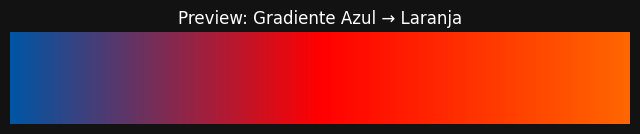

In [0]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Definir cores azul → laranja
cores_azul_laranja = [
    "#0055A5",  # Azul médio (Azul)
    "#FF0000",  # Vermelho
    "#FF6600",  # Laranja (GOL)
]

# Criar cmap personalizado
cmap_azul_laranja = LinearSegmentedColormap.from_list("AzulLaranja", cores_azul_laranja, N=256)

# Visualizar gradiente
gradient = np.linspace(0, 1, 256).reshape(1, -1)

fig, ax = plt.subplots(figsize=(8, 1.2))
ax.imshow(gradient, aspect='auto', cmap=cmap_azul_laranja)
ax.set_axis_off()
plt.title("Preview: Gradiente Azul → Laranja", color='white')

# Fundo escuro para visualizar melhor
fig.patch.set_facecolor('#121212')
ax.set_facecolor('#121212')

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.facecolor": "#121212",
    "figure.facecolor": "#121212",
    "savefig.facecolor": "#121212",
    "axes.edgecolor": "#444444",
    "axes.labelcolor": "#e0e0e0",
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.color": "#cccccc",
    "ytick.color": "#cccccc",
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "text.color": "#e0e0e0",
    "legend.edgecolor": "#444444",
    "legend.facecolor": "#1e1e1e",
    "legend.fontsize": 10,
    "font.family": "DejaVu Sans"
})

plt.show()


## Criação Spark Session

Nesta fase, o conjunto de dados completo é carregado. Considerando a natureza de Big Data da base, uma amostra representativa de 5% é criada. Essa estratégia permite um ciclo de desenvolvimento e teste mais rápido, crucial para a prototipagem de modelos de Machine Learning.

In [0]:
csv_file_path = "/FileStore/tables/base_projeto_integrador_bigdata/*.csv"
df_total = spark.read.csv(csv_file_path, header=True, inferSchema=True)
print(f"O dataset total foi carregado com sucesso. Ele contém {df_total.count()} linhas.")

# Uma amostra de 5% do dataset total é criada para acelerar o desenvolvimento e a experimentação.
# A utilização de uma 'seed' (42, neste caso) garante que a mesma amostra será selecionada
# em execuções subsequentes, o que é vital para a reprodutibilidade dos testes.
df = df_total.sample(False, 0.05, seed=42)
# O DataFrame amostrado é persistido em cache na memória. Isso evita que o Spark precise
# recomputar as mesmas operações para este DataFrame repetidamente, otimizando a performance
# em operações interativas e de tuning.
df.cache()

print(f"Foi criada uma amostra do DataFrame, contendo {df.count()} linhas para prototipagem.")
print("O esquema inferido do DataFrame amostrado é:")
df.printSchema()

O dataset total foi carregado com sucesso. Ele contém 54343518 linhas.
Foi criada uma amostra do DataFrame, contendo 2717209 linhas para prototipagem.
O esquema inferido do DataFrame amostrado é:
root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- A

## Inspeção Inicial da Amostra
Esta célula é dedicada à inspeção rápida da estrutura e do conteúdo inicial do DataFrame amostrado. Isso permite uma verificação visual de que os dados foram carregados e amostrados corretamente.


In [0]:
df.limit(5).toPandas()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2009-01-01,XE,1234,ORD,EWR,1230.0,1234.0,4.0,8.0,1242.0,1511.0,14.0,1559.0,1525.0,-34.0,0.0,None,0.0,149.0,111.0,89.0,719.0,NaN,NaN,NaN,NaN,NaN,None
1,2009-01-01,XE,2096,GSO,EWR,1000.0,959.0,-1.0,14.0,1013.0,1122.0,9.0,1130.0,1131.0,1.0,0.0,None,0.0,90.0,92.0,69.0,446.0,NaN,NaN,NaN,NaN,NaN,None
2,2009-01-01,XE,2111,EWR,AVL,905.0,900.0,-5.0,22.0,922.0,1054.0,4.0,1123.0,1058.0,-25.0,0.0,None,0.0,138.0,118.0,92.0,583.0,NaN,NaN,NaN,NaN,NaN,None
3,2009-01-01,XE,2138,RDU,EWR,850.0,849.0,-1.0,8.0,857.0,1000.0,6.0,1017.0,1006.0,-11.0,0.0,None,0.0,87.0,77.0,63.0,416.0,NaN,NaN,NaN,NaN,NaN,None
4,2009-01-01,XE,2144,MHT,EWR,1025.0,1025.0,0.0,15.0,1040.0,1132.0,15.0,1150.0,1147.0,-3.0,0.0,None,0.0,85.0,82.0,52.0,209.0,NaN,NaN,NaN,NaN,NaN,None


## Tratamento de Nulos e Criação de Features Temporais na Amostra
Nesta etapa do pré-processamento, os valores ausentes (nulos) são tratados e as colunas que representam o tempo (ano, mês, dia da semana) são extraídas da data do voo. O racional é preparar os dados para que o modelo possa interpretá-los corretamente e enriquecer o dataset com informações temporais relevantes.



In [0]:
# Antes de qualquer tratamento, é útil verificar a contagem de valores nulos por coluna.
print("Contagem de valores nulos por coluna (antes do tratamento detalhado):")
df.select([sum(col(column_name).isNull().cast("int")).alias(column_name) for column_name in df.columns]).toPandas()

# Define uma lista de colunas numéricas que, se contiverem nulos, serão preenchidas com 0.
# A escolha do '0' para estas colunas de atraso e tempo baseia-se na premissa de que
# um valor nulo pode indicar a ausência de atraso ou de registro de tempo para aquele evento específico.
delay_and_time_cols_to_fillna_with_zero = [
    "CRS_DEP_TIME", "DEP_TIME", "DEP_DELAY", "TAXI_OUT", "WHEELS_OFF", "WHEELS_ON", "TAXI_IN",
    "CRS_ARR_TIME", "ARR_TIME", "ARR_DELAY", "CANCELLED", "DIVERTED", "CRS_ELAPSED_TIME",
    "ACTUAL_ELAPSED_TIME", "AIR_TIME", "DISTANCE", "CARRIER_DELAY", "WEATHER_DELAY",
    "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"
]

# Itera sobre a lista e aplica a operação de preenchimento de nulos com 0.
for c in delay_and_time_cols_to_fillna_with_zero:
    if c in df.columns: # Garante que a coluna existe no DataFrame antes de tentar manipulá-la.
        df = df.withColumn(c, when(col(c).isNull(), 0).otherwise(col(c)))

# Para a coluna 'CANCELLATION_CODE', que é categórica, o valor nulo é substituído por "None".
# Isso permite que a ausência de um código de cancelamento seja tratada como uma categoria própria
# e não como um valor numérico zero, o que seria sem sentido.
if 'CANCELLATION_CODE' in df.columns:
    df = df.withColumn("CANCELLATION_CODE", when(col("CANCELLATION_CODE").isNull(), "None").otherwise(col("CANCELLATION_CODE")))

print("\nContagem de valores nulos por coluna (após o tratamento inicial de nulos, esperando zeros para as colunas numéricas preenchidas):")
df.select([sum(col(column_name).isNull().cast("int")).alias(column_name) for column_name in df.columns]).toPandas()

# A coluna 'FL_DATE' é convertida para o tipo DateType, o que é essencial para extrair
# componentes de tempo de forma precisa.
if 'FL_DATE' in df.columns:
    df = df.withColumn("FL_DATE", col("FL_DATE").cast(DateType()))
print("\nColuna 'FL_DATE' convertida para o tipo Date.")

# As colunas 'year', 'month' e 'day_of_week' são extraídas de 'FL_DATE'.
# Essas features temporais são cruciais, pois atrasos de voos são frequentemente influenciados
# por sazonalidade (mês, ano) e padrões semanais (dia da semana).
df = df.withColumn("year", year(df.FL_DATE))
df = df.withColumn("month", month(df.FL_DATE))
df = df.withColumn("day_of_week", dayofweek(df.FL_DATE))
print("Colunas de tempo (year, month, day_of_week) criadas.")

df.cache() # O DataFrame é novamente persistido em cache após essas transformações.
print("DataFrame em cache após tratamento inicial de nulos e criação de features temporais.")

Contagem de valores nulos por coluna (antes do tratamento detalhado):

Contagem de valores nulos por coluna (após o tratamento inicial de nulos, esperando zeros para as colunas numéricas preenchidas):

Coluna 'FL_DATE' convertida para o tipo Date.
Colunas de tempo (year, month, day_of_week) criadas.
DataFrame em cache após tratamento inicial de nulos e criação de features temporais.


## Criação da Variável Target (flag_delayed) e Nova Feature de Atraso Percentual na Amostra
Nesta fase, a variável alvo (flag_delayed) é definida, representando se um voo teve algum tipo de problema (atraso na partida/chegada, cancelamento ou desvio). Além disso, uma nova feature ARRIVAL_DELAY_PERCENTAGE é calculada para quantificar a severidade dos atrasos. É fundamental que estas operações sejam realizadas antes da remoção final de colunas, pois dependem de dados que, de outra forma, seriam descartados por questões de data leakage.

In [0]:
# A variável 'flag_delayed' é criada para ser o alvo do modelo (0 = no problem, 1 = problem/delayed).
# Um voo é classificado com 'problema' se:
# - Houve atraso na partida (DEP_DELAY > 0) OU
# - Houve atraso na chegada (ARR_DELAY > 0) OU
# - Foi cancelado (CANCELLED == 1) OU
# - Foi desviado (DIVERTED == 1).
# Essa definição mais abrangente busca capturar qualquer tipo de falha no cumprimento do plano de voo.
df = df.withColumn(
    "flag_delayed",
    when(
        (col("DEP_DELAY") > 0) | (col("ARR_DELAY") > 0) | (col("CANCELLED") == 1) | (col("DIVERTED") == 1),
        1
    ).otherwise(0)
)
print("Coluna 'flag_delayed' (variável target do modelo) criada com uma definição abrangente de 'problema no voo'.")

# Uma nova feature, 'ARRIVAL_DELAY_PERCENTAGE', é calculada.
# Ela representa o atraso na chegada como uma porcentagem do tempo total de voo ('AIR_TIME').
# Essa feature é projetada para capturar a *severidade* do atraso, o que pode ser um indicador
# mais robusto para o modelo do que apenas a existência de um atraso.
# É crucial tratar divisões por zero ou nulos em 'AIR_TIME' e 'ARR_DELAY' para evitar erros.
df = df.withColumn(
    "ARRIVAL_DELAY_PERCENTAGE",
    when(
        (col("AIR_TIME").isNull()) | (col("AIR_TIME") <= 0) | (col("ARR_DELAY").isNull()) | (col("ARR_DELAY") <= 0),
        0.0 # Define a porcentagem como 0.0 se AIR_TIME for inválido ou se não houver atraso.
    ).otherwise(
        (col("ARR_DELAY") / col("AIR_TIME")) * 100
    )
)
print("Coluna 'ARRIVAL_DELAY_PERCENTAGE' (atraso na chegada como % do tempo de voo) criada.")

# Uma flag binária opcional, 'SEVERE_ARRIVAL_DELAY', é criada a partir da porcentagem de atraso.
# Isso pode ser útil para análises ou como uma feature categórica se a severidade binária for mais relevante.
# O limiar de 10.0% pode ser ajustado com base na análise de negócio ou no tuning.
delay_threshold_percentage = 10.0 # Exemplo de limiar: 10%
df = df.withColumn(
    "SEVERE_ARRIVAL_DELAY",
    when(col("ARRIVAL_DELAY_PERCENTAGE") > delay_threshold_percentage, 1).otherwise(0)
)
print(f"Coluna 'SEVERE_ARRIVAL_DELAY' (indicador binário de atraso severo) criada com limiar de {delay_threshold_percentage}%.")

# Exibe algumas linhas com as novas colunas para uma inspeção visual, focando em voos com 'problema'.
print("\nExemplo de dados com as novas features de atraso percentual e a variável target:")
df.select("DEP_DELAY", "ARR_DELAY", "AIR_TIME", "ARRIVAL_DELAY_PERCENTAGE", "SEVERE_ARRIVAL_DELAY", "flag_delayed").filter(col("flag_delayed") == 1).limit(10).toPandas()

df.cache() # O DataFrame é recacheado após a adição das novas features.
print("DataFrame em cache após criação de target e features de atraso percentual.")

Coluna 'flag_delayed' (variável target do modelo) criada com uma definição abrangente de 'problema no voo'.
Coluna 'ARRIVAL_DELAY_PERCENTAGE' (atraso na chegada como % do tempo de voo) criada.
Coluna 'SEVERE_ARRIVAL_DELAY' (indicador binário de atraso severo) criada com limiar de 10.0%.

Exemplo de dados com as novas features de atraso percentual e a variável target:
DataFrame em cache após criação de target e features de atraso percentual.


## Remoção Final de Colunas e Identificação de Features na Amostra
Esta célula é vital para a integridade do modelo. Removemos as colunas que podem levar a data leakage (ou seja, informações que o modelo não teria no momento da previsão real) ou que são redundantes/irrelevantes. Em seguida, identificamos quais colunas restarão como features numéricas e categóricas para o modelo.

In [0]:
# Define uma lista abrangente de colunas a serem removidas.
# O racional para a remoção é que estas colunas ou:
# - Contêm a informação do resultado que queremos prever (ex: DEP_DELAY, ARR_DELAY, CANCELLED).
# - Só estariam disponíveis após o evento do voo, tornando-as inviáveis para previsão (ex: DEP_TIME, ARR_TIME).
# - São causas específicas de atraso, o que seria data leakage (ex: CARRIER_DELAY, WEATHER_DELAY).
# - São redundantes ou não contribuem significativamente (ex: Unnamed: 27, tempos de taxiamento específicos).
columns_to_drop_final = [
    "FL_DATE",               # Data já extraída em year, month, day_of_week
    "DEP_TIME",              # Hora real de partida (data leakage)
    "ARR_TIME",              # Hora real de chegada (data leakage)
    "DEP_DELAY",             # Atraso na partida (componente do target, data leakage)
    "ARR_DELAY",             # Atraso na chegada (componente do target, data leakage)
    "CANCELLED",             # Indicador de cancelamento (componente do target, data leakage)
    "DIVERTED",              # Indicador de desvio (componente do target, data leakage)
    "ACTUAL_ELAPSED_TIME",   # Tempo de voo real (contém informação do atraso, data leakage)
    "CARRIER_DELAY",         # Causa específica de atraso (data leakage)
    "WEATHER_DELAY",         # Causa específica de atraso (data leakage)
    "NAS_DELAY",             # Causa específica de atraso (data leakage)
    "SECURITY_DELAY",        # Causa específica de atraso (data leakage)
    "LATE_AIRCRAFT_DELAY",   # Causa específica de atraso (data leakage)
    "Unnamed: 27",           # Coluna sem sentido identificada previamente
    "TAXI_OUT",              # Tempo de taxiamento de saída (data leakage indireto)
    "WHEELS_OFF",            # Hora da saída das rodas do chão (data leakage indireto)
    "WHEELS_ON",             # Hora das rodas tocarem o chão (data leakage indireto)
    "TAXI_IN",               # Tempo de taxiamento de chegada (data leakage indireto)
    "AIR_TIME"               # Tempo de voo (usada para criar 'ARRIVAL_DELAY_PERCENTAGE', mas agora redundante como feature)
]

# Antes de remover, filtramos a lista para garantir que apenas colunas existentes sejam processadas.
# Isso previne erros se alguma coluna já não estiver presente por algum motivo.
columns_to_drop_final = [c for c in columns_to_drop_final if c in df.columns]

# A operação de 'drop' é aplicada para remover as colunas selecionadas.
df = df.drop(*columns_to_drop_final)
print(f"Colunas removidas do DataFrame amostrado: {columns_to_drop_final}")
print("As colunas de data leakage e irrelevantes foram removidas da amostra com sucesso.")

# O DataFrame é recacheado após a remoção final de colunas.
df.cache()
print("DataFrame em cache após remoção de colunas finais.")

# Identificação dinâmica das features restantes:
# Percorremos o esquema do DataFrame para classificar as colunas restantes em numéricas ou categóricas.
# A variável alvo ('flag_delayed') e a coluna 'Unnamed: 27' são explicitamente excluídas das features.
target_col = "flag_delayed"
numerical_features = []
categorical_features = []

for field in df.schema:
    if field.name not in columns_to_drop_final and field.name != target_col and field.name != 'Unnamed: 27':
        if isinstance(field.dataType, StringType):
            categorical_features.append(field.name)
        elif isinstance(field.dataType, (DoubleType, IntegerType, LongType)):
            numerical_features.append(field.name)

print(f"\nColunas categóricas finais identificadas para o modelo: {categorical_features}")
print(f"Colunas numéricas finais identificadas para o modelo: {numerical_features}")

Colunas removidas do DataFrame amostrado: ['FL_DATE', 'DEP_TIME', 'ARR_TIME', 'DEP_DELAY', 'ARR_DELAY', 'CANCELLED', 'DIVERTED', 'ACTUAL_ELAPSED_TIME', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 27', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'AIR_TIME']
As colunas de data leakage e irrelevantes foram removidas da amostra com sucesso.
DataFrame em cache após remoção de colunas finais.

Colunas categóricas finais identificadas para o modelo: ['OP_CARRIER', 'ORIGIN', 'DEST', 'CANCELLATION_CODE']
Colunas numéricas finais identificadas para o modelo: ['OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE', 'year', 'month', 'day_of_week', 'ARRIVAL_DELAY_PERCENTAGE', 'SEVERE_ARRIVAL_DELAY']


## Visualização do dataframe para o modelo

In [0]:
df.limit(5).toPandas()

,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,CANCELLATION_CODE,CRS_ELAPSED_TIME,DISTANCE,year,month,day_of_week,flag_delayed,ARRIVAL_DELAY_PERCENTAGE,SEVERE_ARRIVAL_DELAY
0,XE,1234,ORD,EWR,1230.0,1559.0,None,149.0,719.0,2009,1,5,1,0.000000,0
1,XE,2096,GSO,EWR,1000.0,1130.0,None,90.0,446.0,2009,1,5,1,1.449275,0
2,XE,2111,EWR,AVL,905.0,1123.0,None,138.0,583.0,2009,1,5,0,0.000000,0
3,XE,2138,RDU,EWR,850.0,1017.0,None,87.0,416.0,2009,1,5,0,0.000000,0
4,XE,2144,MHT,EWR,1025.0,1150.0,None,85.0,209.0,2009,1,5,0,0.000000,0


In [0]:
from pyspark.sql.functions import col, count, when, round

contagem = df.groupBy("ORIGIN").agg(
    count("*").alias("total_voos"),
    count(when(col("flag_delayed") == 1, True)).alias("voos_atrasados")
).withColumn(
    "percentual_atrasos", round((col("voos_atrasados") / col("total_voos")) * 100, 2)
).orderBy(col("percentual_atrasos").desc())

contagem.show()

+------+----------+--------------+------------------+
|ORIGIN|total_voos|voos_atrasados|percentual_atrasos|
+------+----------+--------------+------------------+
|   SPN|         2|             2|             100.0|
|   SHD|         2|             2|             100.0|
|   CGI|         2|             2|             100.0|
|   AZA|         5|             4|              80.0|
|   CKB|         4|             3|              75.0|
|   STC|        25|            18|              72.0|
|   CYS|        33|            22|             66.67|
|   IFP|        11|             7|             63.64|
|   GUM|       137|            86|             62.77|
|   STS|        59|            37|             62.71|
|   DAL|     23962|         14973|             62.49|
|   MDW|     39420|         24359|             61.79|
|   PPG|        26|            16|             61.54|
|   HOU|     24772|         15059|             60.79|
|   PBG|        58|            35|             60.34|
|   ILG|        50|         

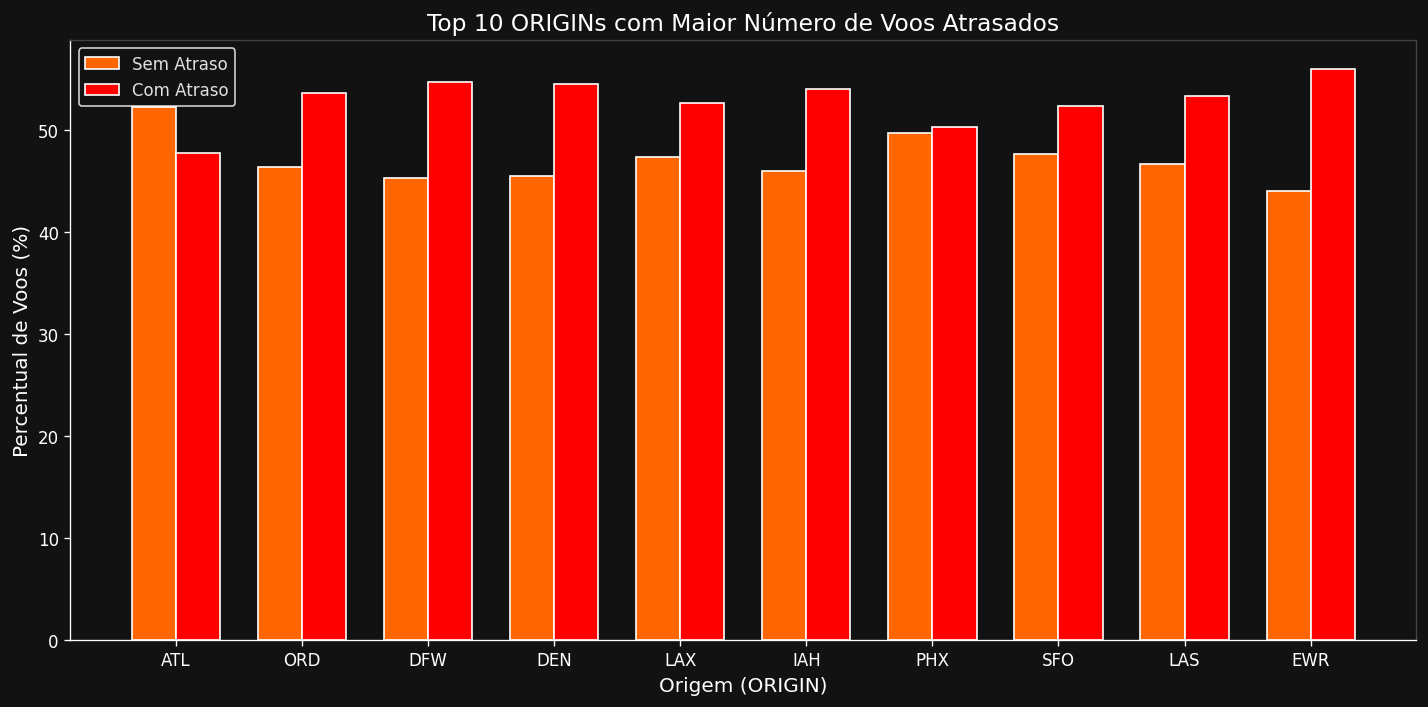

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from pyspark.sql.functions import count, when, col, round

# Agrupar e calcular atrasos em PySpark
contagem_spark = df.groupBy("ORIGIN").agg(
    count("*").alias("total_voos"),
    count(when(col("flag_delayed") == 1, True)).alias("voos_atrasados")
).withColumn(
    "percentual_atrasos", round((col("voos_atrasados") / col("total_voos")) * 100, 2)
).orderBy(col("voos_atrasados").desc())

# Converter para pandas
contagem = contagem_spark.toPandas()

# Calcular complementares em pandas
contagem['percentual_sem_atraso'] = 100 - contagem['percentual_atrasos']

# Selecionar top 10
contagem = contagem.head(10)

# Gráfico
x = np.arange(len(contagem))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(
    x - width/2,
    contagem['percentual_sem_atraso'],
    width,
    label='Sem Atraso',
    color="#FF6600",
    edgecolor='white'
)

ax.bar(
    x + width/2,
    contagem['percentual_atrasos'],
    width,
    label='Com Atraso',
    color="#FF0000",
    edgecolor='white'
)

# Ajustes visuais para fundo escuro
fig.patch.set_facecolor('#121212')
ax.set_facecolor('#121212')
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

ax.set_ylabel('Percentual de Voos (%)', color = 'white')
ax.set_xlabel('Origem (ORIGIN)', color = 'white')
ax.set_title('Top 10 ORIGINs com Maior Número de Voos Atrasados')
ax.set_xticks(x)
ax.set_xticklabels(contagem['ORIGIN'], color='white')
ax.legend(facecolor='#121212', edgecolor='white')

plt.tight_layout()
plt.show()


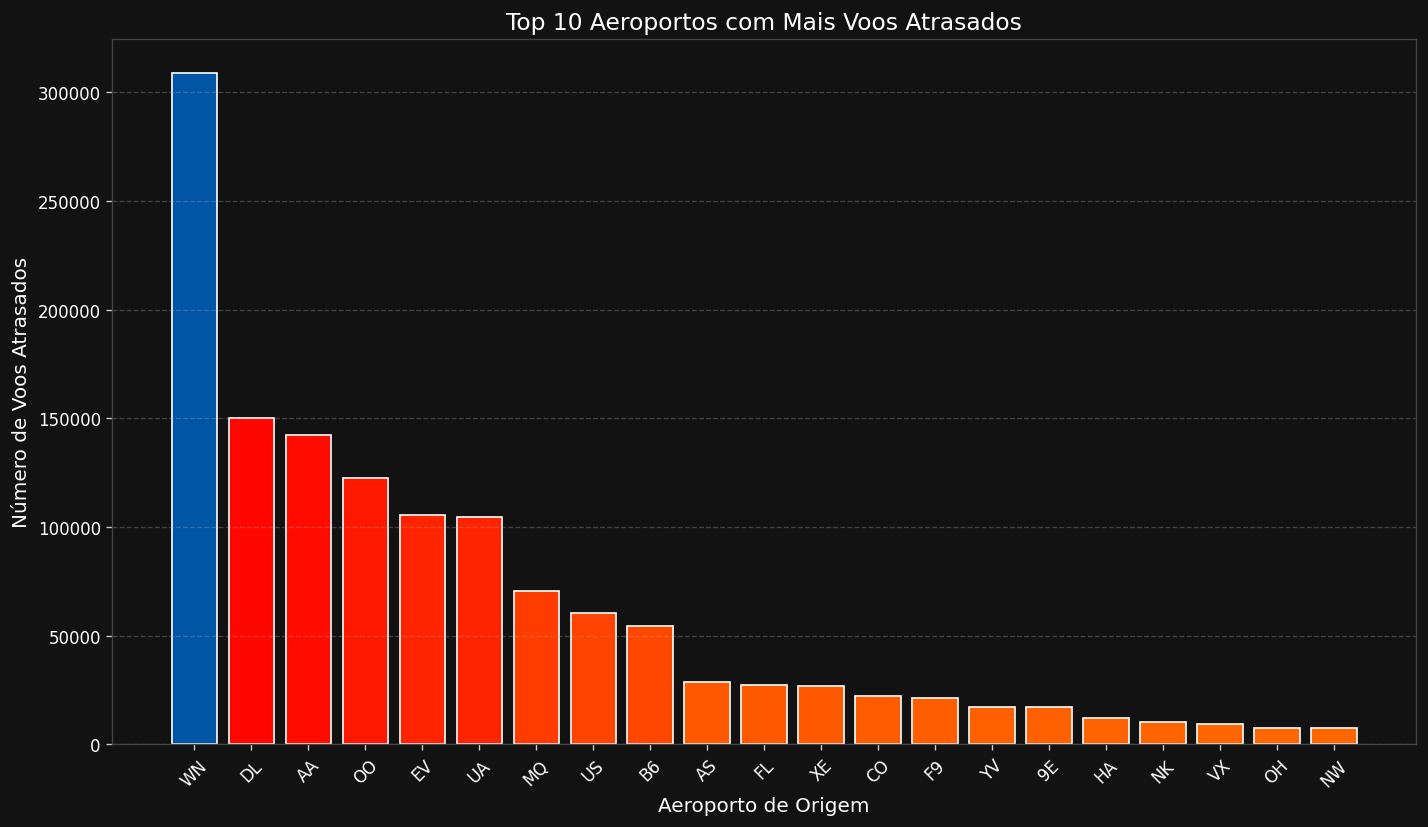

In [0]:
# Gráfico refinado de OP_CARRIERS com degradê azul → laranja e cores vivas

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from matplotlib import cm

# Agregar e ordenar os dados
df_grouped = df.groupBy("OP_CARRIER") \
    .agg(sum("flag_delayed").alias("sum_flag_delayed")) \
    .orderBy(col("sum_flag_delayed").desc())

# Converter para pandas
pdf = df_grouped.toPandas()

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Simulação do seu DataFrame já carregado em pdf

# Criar colormap azul → vermelho → laranja
cores_azul_vermelho_laranja = ["#0055A5", "#FF0000", "#FF6600"]
cmap_avl = LinearSegmentedColormap.from_list(
    "AzulVermelhoLaranja",
    cores_azul_vermelho_laranja,
    N=256
)

# Função para gerar cores invertendo a escala (forçando azul nos maiores)
def gerar_cores_forcando_azul(valores, cmap):
    valores_norm = (valores - valores.min()) / (valores.max() - valores.min() + 1e-9)
    valores_norm = 1 - valores_norm  # inverte para azul nos maiores
    cores = [cmap(v) for v in valores_norm]
    return cores

# Gerar cores
cores = gerar_cores_forcando_azul(pdf['sum_flag_delayed'], cmap_avl)

# Plot
plt.figure(figsize=(12, 7))
plt.bar(pdf['OP_CARRIER'], pdf['sum_flag_delayed'], color=cores, edgecolor='white')

# Layout escuro refinado
plt.xticks(rotation=45, color='white')
plt.yticks(color='white')
plt.xlabel('Aeroporto de Origem', color='white')
plt.ylabel('Número de Voos Atrasados', color='white')
plt.title('Top 10 Aeroportos com Mais Voos Atrasados', color='white')
plt.grid(axis='y', linestyle='--', alpha=0.3)

fig = plt.gcf()
fig.patch.set_facecolor('#121212')
plt.gca().set_facecolor('#121212')

plt.tight_layout()
plt.show()



### A companhia aerea WN apresentou o maior número de atrasos em voos.

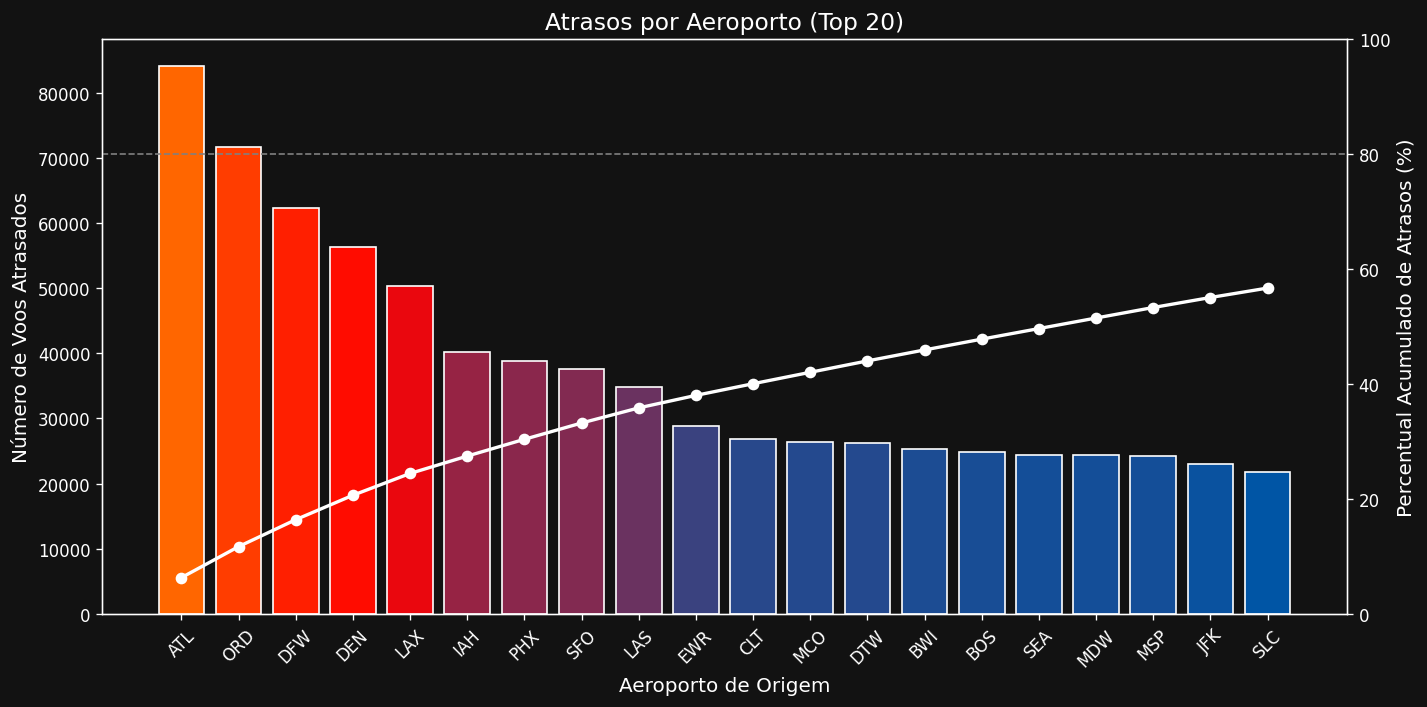

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Agrupar por aeroporto de origem e contar atrasos
df_delays = df.filter(df["flag_delayed"] == 1)
df_grouped = df_delays.groupBy("ORIGIN").count().withColumnRenamed("count", "qtd_atrasos")

# Converter para Pandas
df_grouped_pd = df_grouped.toPandas()

# Ordenar e calcular percentuais
df_grouped_pd = df_grouped_pd.sort_values(by="qtd_atrasos", ascending=False)
df_grouped_pd["percentual"] = df_grouped_pd["qtd_atrasos"] / df_grouped_pd["qtd_atrasos"].sum() * 100
df_grouped_pd["percentual_acumulado"] = df_grouped_pd["percentual"].cumsum()

# Selecionar top 20 aeroportos
top20 = df_grouped_pd.head(20)

# Criar paleta degradê azul → vermelho → laranja
cores_avl = ["#0055A5", "#FF0000", "#FF6600"]
cmap_avl = LinearSegmentedColormap.from_list("azul_vermelho_laranja", cores_avl, N=256)

# Gerar cores degradê conforme quantidade de atrasos
norm = (top20["qtd_atrasos"] - top20["qtd_atrasos"].min()) / (top20["qtd_atrasos"].max() - top20["qtd_atrasos"].min() + 1e-9)
cores = [cmap_avl(n) for n in norm]

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras
bars = ax1.bar(top20["ORIGIN"], top20["qtd_atrasos"], color=cores, edgecolor='white')
ax1.set_ylabel("Número de Voos Atrasados", fontsize=12, color='white')
ax1.set_xlabel("Aeroporto de Origem", fontsize=12, color='white')
ax1.tick_params(axis='x', rotation=45, colors='white')
ax1.tick_params(axis='y', colors='white')

# Linha de Pareto
ax2 = ax1.twinx()
ax2.plot(top20["ORIGIN"], top20["percentual_acumulado"], color='white', marker='o', linewidth=2)
ax2.set_ylabel("Percentual Acumulado de Atrasos (%)", fontsize=12, color='white')
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', colors='white')

# Linha de referência 80%
ax2.axhline(80, color='gray', linestyle='--', linewidth=1)

# Título
ax1.set_title("Atrasos por Aeroporto (Top 20)", fontsize=14, color='white')

# Tema escuro
fig.patch.set_facecolor('#121212')
ax1.set_facecolor('#121212')
ax2.set_facecolor('#121212')

# Bordas brancas
for spine in ax1.spines.values():
    spine.set_edgecolor('white')
for spine in ax2.spines.values():
    spine.set_edgecolor('white')

plt.tight_layout()
plt.show()


### Construindo um gráfico de Pareto vemos que os 20 aeroportos com mais atrasos representam quase 60% do total de atrasos na base.


--- Geração do Gráfico de Barras Agrupadas: Top 10 Origens com Paleta Degradê Azul, Vermelho e Laranja ---


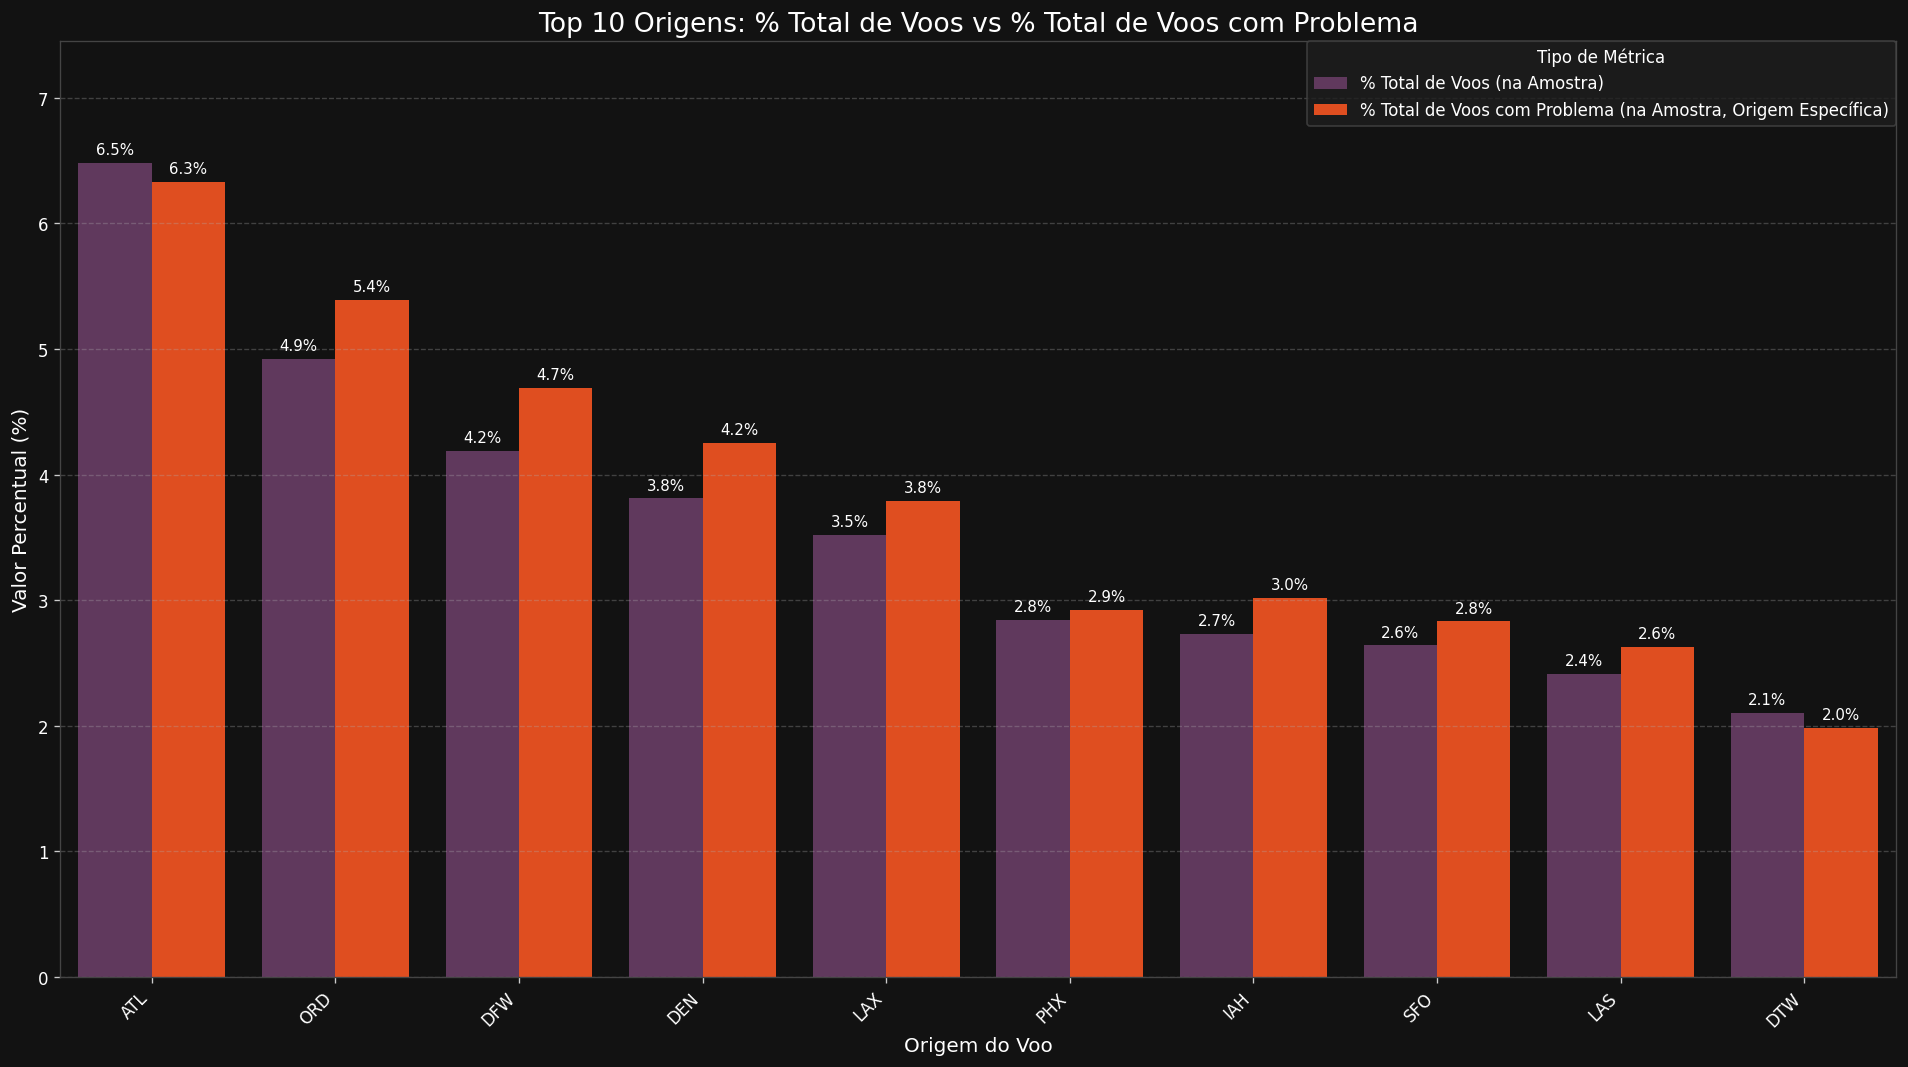

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from pyspark.sql.functions import col, count, sum, lit, round, desc, when

print("\n--- Geração do Gráfico de Barras Agrupadas: Top 10 Origens com Paleta Degradê Azul, Vermelho e Laranja ---")

# 1. Calcular o total de voos para cada origem e o total de voos COM PROBLEMA para cada origem.
# O DataFrame 'df' (a amostra) contém 'ORIGIN' e 'flag_delayed'.
origin_stats = df.groupBy("ORIGIN").agg(
    count(col("ORIGIN")).alias("Total_Voos_Origem"),
    sum(col("flag_delayed")).alias("Voos_Com_Problema_Dessa_Origem")
)

# 2. Calcular o PERCENTUAL de voos de cada origem em relação ao TOTAL de voos na amostra.
total_flights_in_sample = df.count()
origin_stats = origin_stats.withColumn(
    "Pct_Total_Voos_Na_Amostra",
    round((col("Total_Voos_Origem") / lit(total_flights_in_sample)) * 100, 2)
)

# 3. Calcular o PERCENTUAL de voos COM PROBLEMA PARTINDO DESSA ORIGEM em relação ao TOTAL de voos COM PROBLEMA na amostra.
# Primeiro, precisamos do total de voos com problema em toda a amostra.
total_problem_flights_in_sample = df.filter(col("flag_delayed") == 1).count()

# Evitar divisão por zero se não houver voos com problema na amostra.
origin_stats = origin_stats.withColumn(
    "Pct_Voos_Com_Problema_Global_Dessa_Origem",
    round(
        when(lit(total_problem_flights_in_sample) == 0, 0.0) # Se não há voos com problema no geral
        .otherwise((col("Voos_Com_Problema_Dessa_Origem") / lit(total_problem_flights_in_sample)) * 100),
        2
    )
)

# 4. Selecionar as 10 origens com mais voos (baseado em 'Total_Voos_Origem').
top_10_origins = origin_stats.orderBy(desc("Total_Voos_Origem")).limit(10)

# 5. Coletar os dados para o Pandas para plotagem.
top_10_origins_pd = top_10_origins.toPandas()

# 6. Preparar os dados para o gráfico de barras agrupadas (formato "melted" para seaborn).
# As colunas a serem "derretidas" são os dois novos percentuais calculados.
top_10_origins_melted = top_10_origins_pd.melt(
    id_vars=['ORIGIN', 'Total_Voos_Origem', 'Voos_Com_Problema_Dessa_Origem'],
    value_vars=['Pct_Total_Voos_Na_Amostra', 'Pct_Voos_Com_Problema_Global_Dessa_Origem'],
    var_name='Tipo_Métrica',
    value_name='Valor_Percentual'
)

# Renomear os tipos de métrica para melhor visualização na legenda.
top_10_origins_melted['Tipo_Métrica'] = top_10_origins_melted['Tipo_Métrica'].replace({
    'Pct_Total_Voos_Na_Amostra': '% Total de Voos (na Amostra)',
    'Pct_Voos_Com_Problema_Global_Dessa_Origem': '% Total de Voos com Problema (na Amostra, Origem Específica)'
})

# Assegurar a ordem das origens no gráfico (da maior % total de voos para a menor).
top_10_origins_ordered = top_10_origins_pd['ORIGIN'].tolist()
top_10_origins_melted['ORIGIN'] = pd.Categorical(top_10_origins_melted['ORIGIN'], categories=top_10_origins_ordered, ordered=True)
top_10_origins_melted = top_10_origins_melted.sort_values('ORIGIN')


# 6. Paleta degradê azul → vermelho → laranja
cores_avl = ["#0055A5", "#FF0000", "#FF6600"]
cmap_avl = LinearSegmentedColormap.from_list("azul_vermelho_laranja", cores_avl, N=256)

# Gerar cores distintas para as duas métricas a partir da paleta
cor_voos_total = cmap_avl(0.2)     # tom azul
cor_voos_problema = cmap_avl(0.8)  # tom laranja

# 7. Gráfico de Barras Agrupadas com tema escuro
plt.figure(figsize=(16, 9))

ax = sns.barplot(
    x="ORIGIN",
    y="Valor_Percentual",
    hue="Tipo_Métrica",
    data=top_10_origins_melted,
    palette={
        "% Total de Voos (na Amostra)": cor_voos_total,
        "% Total de Voos com Problema (na Amostra, Origem Específica)": cor_voos_problema
    }
)

# Layout escuro
ax.set_facecolor('#121212')
plt.gcf().patch.set_facecolor('#121212')
plt.xlabel("Origem do Voo", fontsize=12, color='white')
plt.ylabel("Valor Percentual (%)", fontsize=12, color='white')
plt.title('Top 10 Origens: % Total de Voos vs % Total de Voos com Problema', fontsize=16, color='white')
plt.xticks(rotation=45, ha='right', color='white')
plt.yticks(color='white')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Legenda clara
leg = plt.legend(title='Tipo de Métrica', loc='upper right', borderaxespad=0.)
plt.setp(leg.get_texts(), color='white')
plt.setp(leg.get_title(), color='white')

# Ajustar limites do eixo y
plt.ylim(0, top_10_origins_melted['Valor_Percentual'].max() * 1.15)

# Adicionar rótulos sobre as barras
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f'{height:.1f}%',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='center',
            xytext=(0, 8),
            textcoords='offset points',
            fontsize=9,
            color='white'
        )

plt.tight_layout()
plt.show()


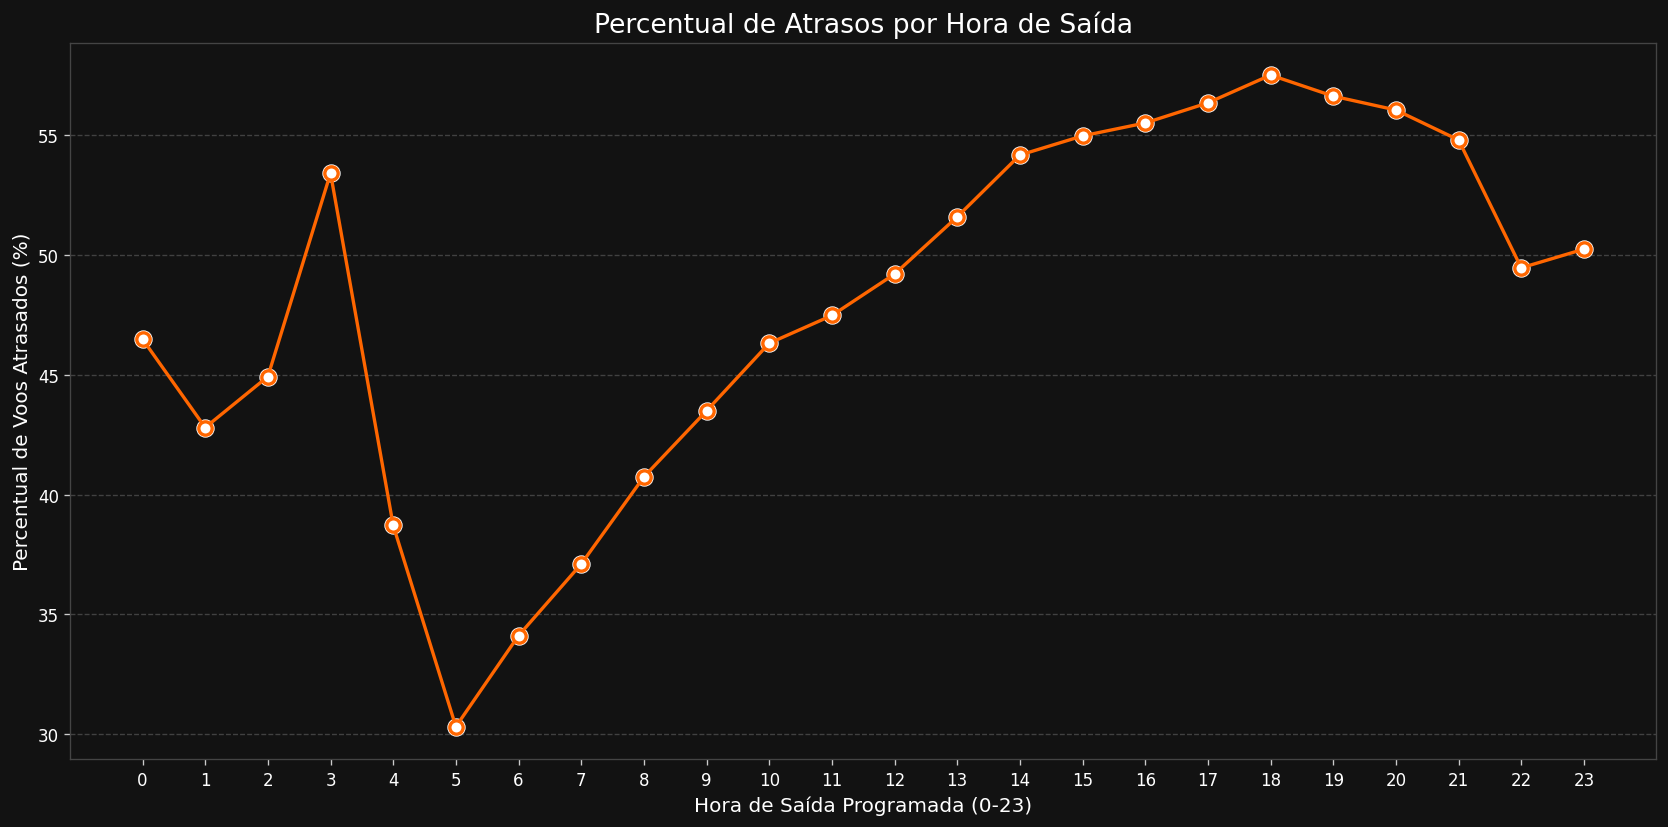

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pyspark.sql.functions import hour, col, count, sum as pyspark_sum, lit, round as pyspark_round

# Criar colormap degradê azul → vermelho → laranja
cores_avl = ["#0055A5", "#FF0000", "#FF6600"]
cmap_avl = LinearSegmentedColormap.from_list("azul_vermelho_laranja", cores_avl, N=256)

# Preparar os dados em PySpark
# Extrair a hora inteira do CRS_DEP_TIME (em formato HHMM), transformando em hora de 0 a 23
# Ajuste para seu caso se CRS_DEP_TIME não for string:
df = df.withColumn("HORA_SAIDA", (col("CRS_DEP_TIME") / 100).cast("int"))

# Contar total de voos por hora
df_total_por_hora = df.groupBy("HORA_SAIDA").agg(count("*").alias("total_voos"))

# Contar total de voos atrasados por hora
df_atrasos_por_hora = df.filter(col("flag_delayed") == 1).groupBy("HORA_SAIDA").agg(count("*").alias("voos_atrasados"))

# Juntar os DataFrames e calcular percentual de atrasos
df_merged = df_total_por_hora.join(df_atrasos_por_hora, on="HORA_SAIDA", how="left").fillna(0)
df_merged = df_merged.withColumn(
    "pct_atrasos",
    pyspark_round((col("voos_atrasados") / col("total_voos")) * 100, 2)
)

# Converter para Pandas
pdf = df_merged.orderBy("HORA_SAIDA").toPandas()

# Plotar o Line Plot
plt.figure(figsize=(14, 7))

# Gerar cores do degradê conforme percentual
norm = (pdf["pct_atrasos"] - pdf["pct_atrasos"].min()) / (pdf["pct_atrasos"].max() - pdf["pct_atrasos"].min() + 1e-9)
colors = [cmap_avl(val) for val in norm]

# Plot
plt.plot(
    pdf["HORA_SAIDA"],
    pdf["pct_atrasos"],
    color='#FF6600',
    marker='o',
    linewidth=2,
    markersize=8,
    markerfacecolor='white',
    markeredgewidth=2
)

# Preenchimento colorido
for x, y, c in zip(pdf["HORA_SAIDA"], pdf["pct_atrasos"], colors):
    plt.scatter(x, y, color=c, s=100, edgecolor='white', linewidth=1)

# Tema escuro refinado
plt.gca().set_facecolor('#121212')
plt.gcf().patch.set_facecolor('#121212')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Labels e título
plt.xlabel("Hora de Saída Programada (0-23)", fontsize=12, color='white')
plt.ylabel("Percentual de Voos Atrasados (%)", fontsize=12, color='white')
plt.title("Percentual de Atrasos por Hora de Saída", fontsize=16, color='white')
plt.xticks(range(0, 24), fontsize=10, color='white')
plt.yticks(fontsize=10, color='white')

plt.tight_layout()
plt.show()


### A maior parte dos voos com atraso saem no período da tarde, das 16h às 21h.

/root/.ipykernel/974/command-7372872559959071-3257650414:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


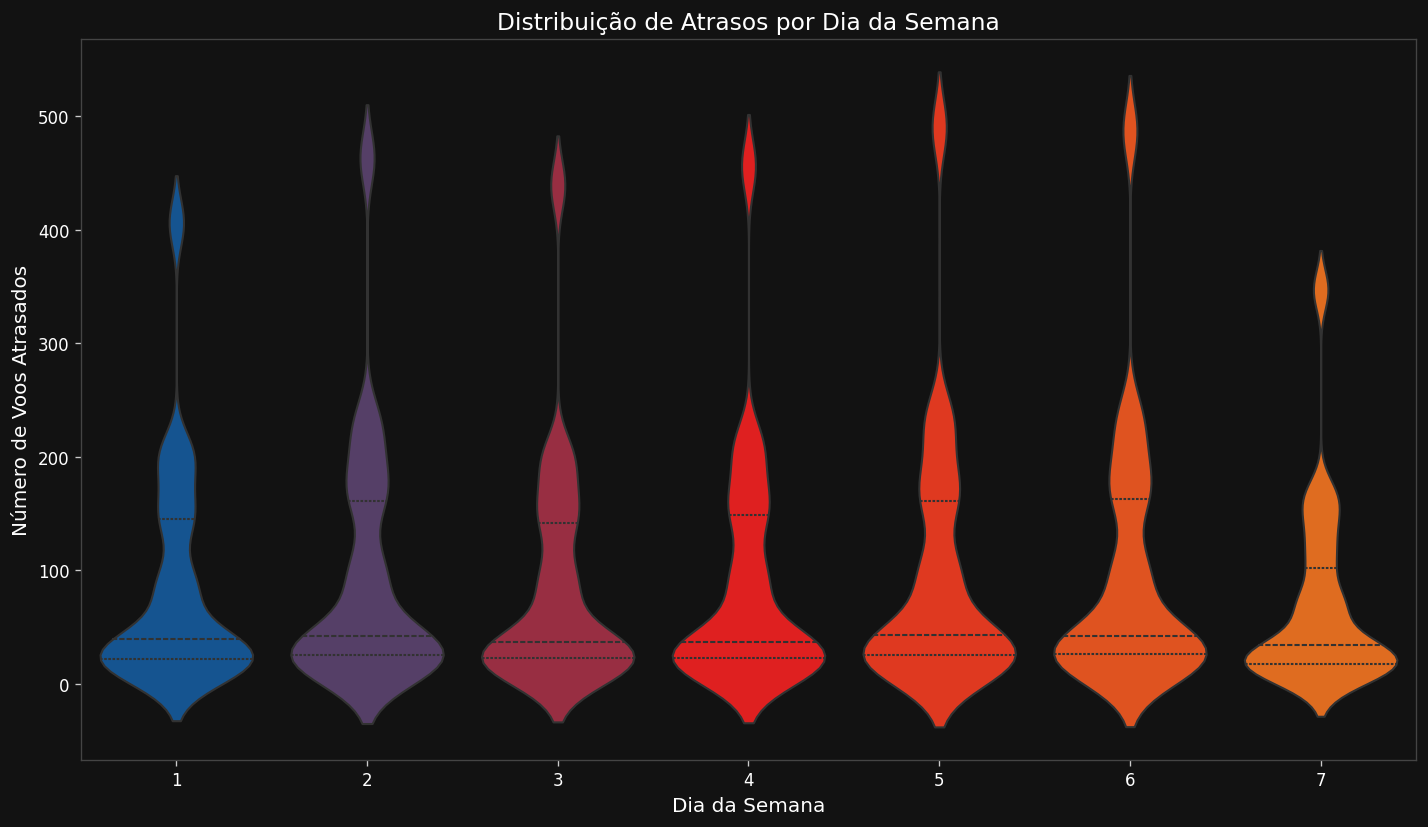

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from pyspark.sql.functions import sum, col

# Agrupar dados em PySpark para posterior análise detalhada
df_grouped = df.groupBy("day_of_week", "OP_CARRIER") \
    .agg(sum("flag_delayed").alias("sum_flag_delayed"))

# Converter para pandas
pdf = df_grouped.toPandas()

# Expandir para uso em Violin Plot:
# Se você tiver dados individuais de atrasos, substitua 'sum_flag_delayed' por 'flag_delayed'
# Caso contrário, se tiver apenas agregados, podemos simular a distribuição replicando valores

# Simulação de expansão de distribuição caso necessário (pode remover se tiver dados reais)
expanded_data = []
for _, row in pdf.iterrows():
    expanded_data.extend([{
        'day_of_week': row['day_of_week'],
        'flag_delayed': row['sum_flag_delayed'] // 100  # ajuste conforme o seu caso
    }] * 100)
pdf_expanded = pd.DataFrame(expanded_data)

# Criar paleta degradê azul → vermelho → laranja
cores_azul_vermelho_laranja = ["#0055A5", "#FF0000", "#FF6600"]
cmap_avl = LinearSegmentedColormap.from_list(
    "AzulVermelhoLaranja",
    cores_azul_vermelho_laranja,
    N=7  # 7 dias da semana
)

# Gerar cores da paleta para cada dia
palette = [cmap_avl(i/6) for i in range(7)]

# Plot Violin
plt.figure(figsize=(12, 7))

sns.violinplot(
    x='day_of_week',
    y='flag_delayed',
    data=pdf_expanded,
    palette=palette,
    inner='quartile'
)

# Layout escuro refinado
plt.title('Distribuição de Atrasos por Dia da Semana', color='white')
plt.xlabel('Dia da Semana', color='white')
plt.ylabel('Número de Voos Atrasados', color='white')
plt.xticks(color='white')
plt.yticks(color='white')

# Fundo escuro
fig = plt.gcf()
fig.patch.set_facecolor('#121212')
plt.gca().set_facecolor('#121212')

plt.tight_layout()
plt.show()


###Voos na quinta e na sexta tendem a atrasar mais, o dia com menos atrasos é sábado.

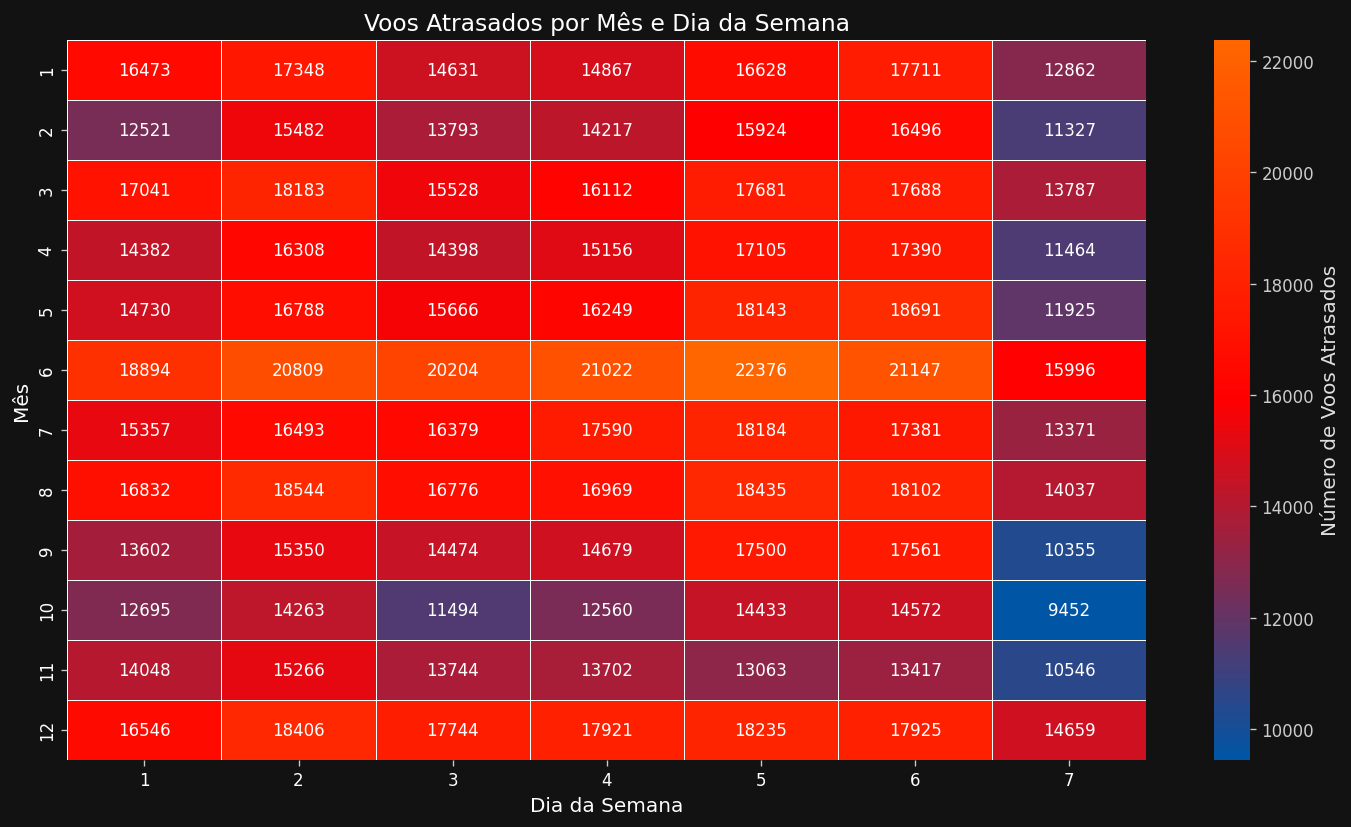

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from pyspark.sql.functions import sum, col

# Agrupar os dados no PySpark
df_grouped = df.groupBy("month", "day_of_week") \
    .agg(sum("flag_delayed").alias("sum_flag_delayed"))

# Converter para pandas
pdf = df_grouped.toPandas()

# Pivotar para formato de heatmap (meses como linhas, dias como colunas)
heatmap_data = pdf.pivot(index='month', columns='day_of_week', values='sum_flag_delayed').fillna(0)

# Criar paleta degradê azul → vermelho → laranja
cores_azul_vermelho_laranja = ["#0055A5", "#FF0000", "#FF6600"]
cmap_avl = LinearSegmentedColormap.from_list(
    "AzulVermelhoLaranja",
    cores_azul_vermelho_laranja,
    N=256
)

# Plot do heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(
    heatmap_data,
    cmap=cmap_avl,
    annot=True,
    fmt=".0f",
    linewidths=.5,
    cbar_kws={'label': 'Número de Voos Atrasados'}
)

# Layout escuro refinado
plt.title('Voos Atrasados por Mês e Dia da Semana', color='white')
plt.xlabel('Dia da Semana', color='white')
plt.ylabel('Mês', color='white')
plt.xticks(color='white')
plt.yticks(color='white')

# Ajustar fundo
fig = plt.gcf()
fig.patch.set_facecolor('#121212')
plt.gca().set_facecolor('#121212')

plt.tight_layout()
plt.show()


### O mês com mais atrasos é junho, seguido por dezembro, o que faz sentido, pois são meses de férias e há uma quantidade voos maior nessas datas. Os meses com menor número de atrasos são outubro e novembro.

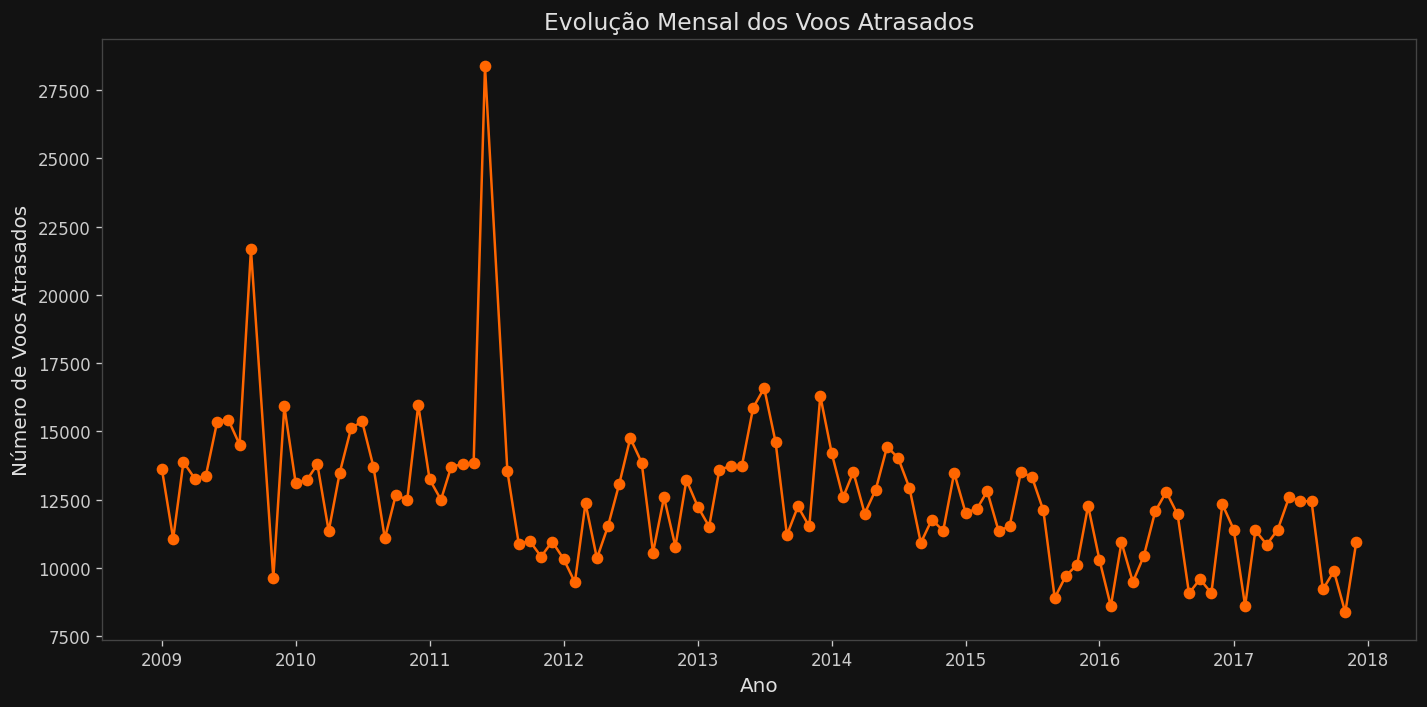

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

df_grouped = df.groupBy("month", "year") \
    .agg(sum("flag_delayed").alias("sum_flag_delayed")) \
    .orderBy(col("sum_flag_delayed").desc())

# Converter para pandas
pdf = df_grouped.toPandas()

# Criar coluna datetime
pdf['date'] = pd.to_datetime(pdf[['year', 'month']].assign(day=1))

# Ordenar pela data, se necessário
pdf = pdf.sort_values('date')

# Plotar gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(pdf['date'], pdf['sum_flag_delayed'], marker='o', color="#FF6600")

# Formatar o eixo X para mostrar apenas os anos
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Ano')
plt.ylabel('Número de Voos Atrasados')
plt.title('Evolução Mensal dos Voos Atrasados')
plt.tight_layout()
plt.show()


### Há um pico de atrasos de voos na metade de 2011, e pesquisas mostram que foi causado por falhas tecnológicas em companhias aéreas principais e mudanças nas regras operacionais.

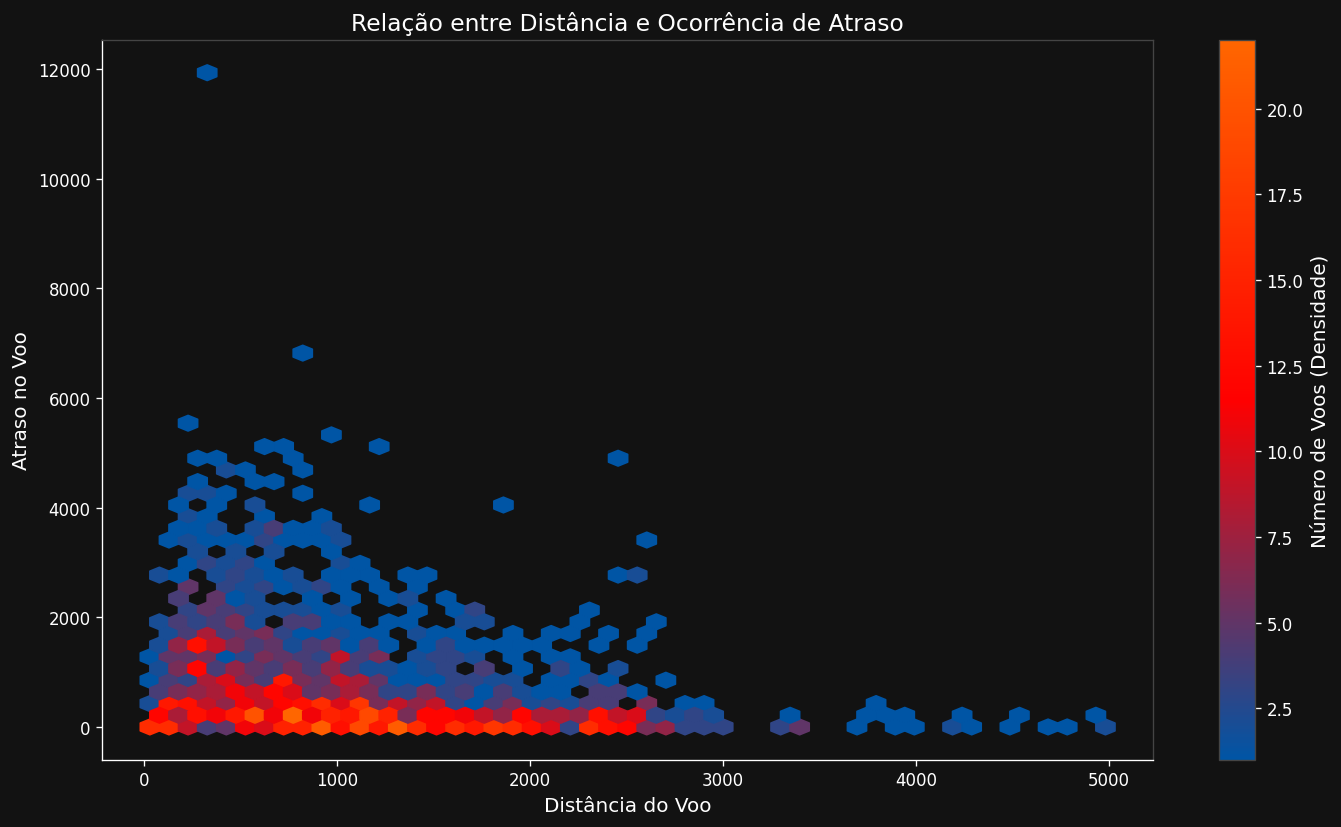

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Agrupar dados em PySpark
df_grouped = df.groupBy("DISTANCE") \
    .agg(sum("flag_delayed").alias("sum_flag_delayed"))

# Converter para pandas
pdf = df_grouped.toPandas()

# Criar colormap degradê azul → vermelho → laranja
cores_azul_vermelho_laranja = ["#0055A5", "#FF0000", "#FF6600"]
cmap_avl = LinearSegmentedColormap.from_list(
    "AzulVermelhoLaranja",
    cores_azul_vermelho_laranja,
    N=256
)

# Ajustar figura
plt.figure(figsize=(12, 7))

# HEXBIN com binagem adequada
hb = plt.hexbin(
    pdf['DISTANCE'],
    pdf['sum_flag_delayed'],
    gridsize=50,    # Ajuste a granularidade conforme a densidade do seu dataset
    cmap=cmap_avl,
    mincnt=1
)

# Barra de cores
cb = plt.colorbar(hb)
cb.set_label('Número de Voos (Densidade)', color='white')
cb.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')

# Labels e título
plt.xlabel('Distância do Voo', color='white')
plt.ylabel('Atraso no Voo', color='white')
plt.title('Relação entre Distância e Ocorrência de Atraso', color='white')

# Tema escuro refinado
fig = plt.gcf()
fig.patch.set_facecolor('#121212')
ax = plt.gca()
ax.set_facecolor('#121212')
ax.tick_params(colors='white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

plt.tight_layout()
plt.show()

## A maior parte da operação ocorre em voos curtos e com poucos atrasos.

## Etapas de Feature Engineering da Amostra
Nesta célula, definimos as etapas de transformação de features utilizando transformers do PySpark ML. Isso inclui a indexação de strings, a codificação one-hot, a vetorização de features e o escalonamento. Estas etapas são construídas como objetos e serão incorporadas nos pipelines dos modelos.

In [0]:
# StringIndexer: Transforma colunas categóricas (string) em colunas de índices numéricos.
# 'handleInvalid="skip"' garante que linhas com valores inválidos sejam ignoradas.
indexers = [StringIndexer(inputCol=col_name, outputCol=f"{col_name}Index", handleInvalid="skip") for col_name in categorical_features]

# OneHotEncoder: Converte as colunas de índices numéricos (saída do StringIndexer)
# em vetores binários, um para cada categoria. Isso é fundamental para modelos que
# não conseguem lidar diretamente com valores categóricos.
encoders = [OneHotEncoder(inputCol=f"{col_name}Index", outputCol=f"{col_name}OHE") for col_name in categorical_features]

# VectorAssembler: Combina todas as features numéricas (tanto as originais quanto as
# resultantes do OneHotEncoder) em um único vetor denso. Este formato de vetor é o
# requisito de entrada para a maioria dos algoritmos de Machine Learning do PySpark.
assembler_inputs = numerical_features + [f"{col_name}OHE" for col_name in categorical_features]
vector_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# StandardScaler: Escala as features numéricas para que tenham média zero e variância unitária.
# Este passo é crucial para modelos como a Regressão Logística, pois a escala das features
# pode afetar a convergência do otimizador e a performance do modelo.
scaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)

print("Todas as etapas de Feature Engineering (StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler) foram definidas.")

Todas as etapas de Feature Engineering (StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler) foram definidas.


## Divisão da Amostra em Conjuntos de Treino e Teste e Balanceamento de Classes
Nesta etapa, a amostra do dataset é dividida em conjuntos de treinamento e teste. Para lidar com o possível desequilíbrio entre as classes de voos (atrasados vs. não atrasados), é calculada uma coluna de pesos de classe para o conjunto de treinamento. Isso é especialmente importante para a Regressão Logística, que pode ser sensível ao desbalanceamento.

In [0]:
# O DataFrame 'df' (amostra) é dividido em conjuntos de treino e teste.
# 80% dos dados são usados para treinamento e 20% para teste.
# A 'seed' garante que a divisão seja a mesma em todas as execuções, para reprodutibilidade.
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
train_df.cache() # O conjunto de treino é cacheado, pois será usado múltiplas vezes no tuning.
test_df.cache()  # O conjunto de teste também é cacheado para avaliações futuras.
print(f"O conjunto de treino da amostra possui {train_df.count()} linhas.")
print(f"O conjunto de teste da amostra possui {test_df.count()} linhas.")

# Para mitigar o problema de classes desbalanceadas (onde uma classe é muito mais frequente que a outra),
# calculamos pesos de classe. Essa técnica é útil para modelos como a Regressão Logística.
# A ideia é dar um peso maior às amostras da classe minoritária, para que o modelo preste mais atenção a elas.
class_counts = train_df.groupBy("flag_delayed").count().collect()
total_count = train_df.count()
# A fórmula calcula um peso inversamente proporcional à frequência da classe.
# O fator 2.0 no denominador ajuda a manter a soma total dos pesos balanceada.
class_weights = {float(row["flag_delayed"]): float(total_count) / (2.0 * float(row["count"])) for row in class_counts}

# Uma nova coluna, 'classWeight', é adicionada ao DataFrame de treino.
# Esta coluna conterá o peso correspondente à classe de cada linha, e será utilizada pela Regressão Logística.
train_df_weighted = train_df.withColumn("classWeight", when(col("flag_delayed") == 1, class_weights[1.0]).otherwise(class_weights[0.0]))
print("\nUma coluna 'classWeight' foi adicionada ao DataFrame de treino da amostra para ponderação de classes.")

train_df_weighted.cache() # O DataFrame de treino ponderado também é cacheado.
print("O DataFrame de treino ponderado da amostra está agora em cache.")

O conjunto de treino da amostra possui 2173067 linhas.
O conjunto de teste da amostra possui 544142 linhas.

Uma coluna 'classWeight' foi adicionada ao DataFrame de treino da amostra para ponderação de classes.
O DataFrame de treino ponderado da amostra está agora em cache.


##Treinamento e Avaliação da Regressão Logística na Amostra (com Tuning Otimizado)
Nesta célula, o modelo de Regressão Logística é configurado, treinado e avaliado utilizando a amostra de dados. A estratégia de CrossValidator com ParamGridBuilder é empregada para otimizar os hiperparâmetros. O grid de busca e o número de folds foram ajustados para um tempo de execução mais eficiente durante a fase de desenvolvimento, balanceando a busca por bons parâmetros com a velocidade.

In [0]:
# 9.1. Configuração do Modelo de Regressão Logística
# O modelo de Regressão Logística é definido. Seus hiperparâmetros (maxIter, regParam, elasticNetParam)
# serão ajustados automaticamente pelo CrossValidator.
# A 'weightCol' é utilizada para o balanceamento de classes.
# 'rawPredictionCol' é essencial para calcular métricas como AUC.
lr = LogisticRegression(labelCol="flag_delayed",
                        featuresCol="features_scaled",
                        maxIter=50, # Um valor inicial e máximo para as iterações do otimizador.
                        regParam=0.01, # Força de regularização, previne overfitting.
                        elasticNetParam=0.0, # Combina L1 (0.0) e L2 (1.0) regularização.
                        weightCol="classWeight", # Coluna de pesos para balanceamento de classes.
                        rawPredictionCol="rawPrediction")

print("\nO modelo de Regressão Logística foi configurado.")

# O pipeline de Regressão Logística é montado, sequenciando as etapas de Feature Engineering
# e o próprio modelo.
pipeline_lr_stages = indexers + encoders + [vector_assembler, scaler, lr]
pipeline_lr = Pipeline(stages=pipeline_lr_stages)
print("O pipeline de Regressão Logística foi criado.")

# 9.2. Tuning de Hiperparâmetros e Cross-Validation para Regressão Logística
# Um grid de hiperparâmetros é definido para o CrossValidator explorar.
# As faixas de valores são escolhidas para uma busca mais rápida em desenvolvimento,
# sendo posteriormente refinadas para a base completa.
# Este grid resultará em 16 combinações de hiperparâmetros (2*2*2*2).
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .addGrid(lr.maxIter, [20, 50]) \
    .build()

# Os avaliadores de desempenho são definidos para calcular diversas métricas importantes.
# O 'BinaryClassificationEvaluator' é ideal para AUC, enquanto o 'MulticlassClassificationEvaluator'
# é usado para acurácia, F1-Score, precisão e recall.
evaluator_lr_auc = BinaryClassificationEvaluator(labelCol="flag_delayed", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_lr_accuracy = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="accuracy")
evaluator_lr_f1 = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="f1")
evaluator_lr_precision = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="weightedPrecision")
evaluator_lr_recall = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="weightedRecall")

# O CrossValidator é configurado para encontrar o melhor modelo.
# Ele treinará o pipeline com cada combinação de hiperparâmetros e validará o desempenho
# usando validação cruzada (numFolds=2 para agilizar em desenvolvimento).
cv_lr = CrossValidator(estimator=pipeline_lr,
                       estimatorParamMaps=paramGrid_lr,
                       evaluator=evaluator_lr_auc, # A métrica principal para a seleção do melhor modelo é a AUC.
                       numFolds=2, # Número de folds reduzido para testes rápidos.
                       seed=42) # Garante a reprodutibilidade da validação cruzada.

print("\nO treinamento do modelo de Regressão Logística com tuning de hiperparâmetros está sendo iniciado. Este processo pode levar algum tempo, dependendo da infraestrutura e do tamanho da amostra, mas está otimizado para o desenvolvimento.")
# O método .fit() do CrossValidator inicia o processo de treinamento e tuning.
# Ele utiliza o DataFrame de treino ponderado (train_df_weighted).
cv_model_lr = cv_lr.fit(train_df_weighted)
# O 'best_model_lr' é o pipeline que obteve o melhor desempenho no CrossValidator.
best_model_lr = cv_model_lr.bestModel
print("O melhor modelo de Regressão Logística foi encontrado e treinado na amostra.")

# 9.3. Predições e Avaliação da Regressão Logística
# O modelo otimizado é utilizado para fazer predições no conjunto de teste da amostra.
predictions_lr = best_model_lr.transform(test_df)
print("As predições com Regressão Logística foram realizadas no conjunto de teste da amostra.")

# As métricas de desempenho são calculadas para a avaliação do modelo.
auc_lr = evaluator_lr_auc.evaluate(predictions_lr)
accuracy_lr = evaluator_lr_accuracy.evaluate(predictions_lr)
f1_lr = evaluator_lr_f1.evaluate(predictions_lr)
precision_lr = evaluator_lr_precision.evaluate(predictions_lr)
recall_lr = evaluator_lr_recall.evaluate(predictions_lr)

# Métricas específicas para a classe positiva (atraso = 1) são calculadas para
# uma avaliação mais aprofundada em cenários de desbalanceamento.
evaluator_lr_precision_class1 = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="precisionByLabel", metricLabel=1.0)
evaluator_lr_recall_class1 = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="recallByLabel", metricLabel=1.0)
precision_lr_class1 = evaluator_lr_precision_class1.evaluate(predictions_lr)
recall_lr_class1 = evaluator_lr_recall_class1.evaluate(predictions_lr)

print("\n--- Métricas da Regressão Logística (na Amostra) ---")
print(f"AUC: {auc_lr:.4f}")
print(f"Acurácia: {accuracy_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")
print(f"Precisão (weighted): {precision_lr:.4f}")
print(f"Recall (weighted): {recall_lr:.4f}")
print(f"Precisão (Classe Atraso=1): {precision_lr_class1:.4f}")
print(f"Recall (Classe Atraso=1): {recall_lr_class1:.4f}")

# Exemplo de predições do modelo na amostra.
print("\nAs 10 primeiras predições da Regressão Logística (na Amostra) são:")
predictions_lr.select("flag_delayed", "rawPrediction", "probability", "prediction").limit(10).toPandas()


O modelo de Regressão Logística foi configurado.
O pipeline de Regressão Logística foi criado.

O treinamento do modelo de Regressão Logística com tuning de hiperparâmetros está sendo iniciado. Este processo pode levar algum tempo, dependendo da infraestrutura e do tamanho da amostra, mas está otimizado para o desenvolvimento.
O melhor modelo de Regressão Logística foi encontrado e treinado na amostra.
As predições com Regressão Logística foram realizadas no conjunto de teste da amostra.

--- Métricas da Regressão Logística (na Amostra) ---
AUC: 0.9089
Acurácia: 0.7354
F1-Score: 0.7135
Precisão (weighted): 0.8257
Recall (weighted): 0.7354
Precisão (Classe Atraso=1): 1.0000
Recall (Classe Atraso=1): 0.4587

As 10 primeiras predições da Regressão Logística (na Amostra) são:


,flag_delayed,rawPrediction,probability,prediction
0,0,"[0.4129266952126813, -0.4129266952126813]","[0.6017894373985041, 0.3982105626014959]",0.0
1,0,"[0.41291703019881654, -0.41291703019881654]","[0.6017871212828336, 0.3982128787171664]",0.0
2,1,"[0.13774341433784018, -0.13774341433784018]","[0.5343815100231184, 0.4656184899768816]",0.0
3,0,"[0.41294119273347857, -0.41294119273347857]","[0.601792911563465, 0.39820708843653496]",0.0
4,0,"[0.4129395818978344, -0.4129395818978344]","[0.6017925255456423, 0.39820747445435767]",0.0
5,0,"[0.4132033249479554, -0.4132033249479554]","[0.6018557267798607, 0.39814427322013934]",0.0
6,0,"[0.41312808367100107, -0.41312808367100107]","[0.6018376969197843, 0.3981623030802157]",0.0
7,1,"[-1.5881935621065624, 1.5881935621065624]","[0.16963820189811502, 0.8303617981018849]",1.0
8,0,"[0.4132799265488729, -0.4132799265488729]","[0.6018740823267331, 0.3981259176732669]",0.0
9,0,"[0.4131215937241447, -0.4131215937241447]","[0.6018361417387394, 0.39816385826126055]",0.0


## Treinamento e Avaliação do Random Forest na Amostra (com Tuning Otimizado)
Esta célula segue a mesma lógica da anterior, mas para o modelo RandomForestClassifier. É configurado um pipeline, realizada a busca de hiperparâmetros otimizada para desenvolvimento e o modelo é avaliado com as mesmas métricas.

In [0]:
# 10.1. Configuração do Modelo RandomForestClassifier
# O modelo de Random Forest é definido. Seus hiperparâmetros (numTrees, maxDepth)
# serão ajustados pelo CrossValidator.
# 'rawPredictionCol' é essencial para calcular métricas como AUC.
rf = RandomForestClassifier(labelCol="flag_delayed", featuresCol="features_scaled",
                            numTrees=20, maxDepth=10, seed=42, rawPredictionCol="rawPrediction") # Valores iniciais para tuning
print("\nO modelo RandomForestClassifier foi configurado (com numTrees e maxDepth iniciais reduzidos para agilizar o tuning).")

# O pipeline para Random Forest é montado, sequenciando as etapas de Feature Engineering
# e o próprio modelo.
pipeline_rf_stages = indexers + encoders + [vector_assembler, scaler, rf]
pipeline_rf = Pipeline(stages=pipeline_rf_stages)
print("O pipeline RandomForestClassifier foi criado.")

# 10.2. Tuning de Hiperparâmetros e Cross-Validation para Random Forest
# Um grid de hiperparâmetros é definido para o CrossValidator explorar.
# As faixas de valores são escolhidas para uma busca mais rápida em desenvolvimento,
# resultando em 4 combinações de hiperparâmetros (2*2).
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# Os avaliadores de desempenho são definidos, os mesmos utilizados para a Regressão Logística.
evaluator_rf_auc = BinaryClassificationEvaluator(labelCol="flag_delayed", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_rf_accuracy = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="accuracy")
evaluator_rf_f1 = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="f1")
evaluator_rf_precision = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="weightedPrecision")
evaluator_rf_recall = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="weightedRecall")

# O CrossValidator é configurado para encontrar o melhor modelo.
# numFolds=2 para agilizar o desenvolvimento; aumentar para 5-10 em produção.
cv_rf = CrossValidator(estimator=pipeline_rf,
                       estimatorParamMaps=paramGrid_rf,
                       evaluator=evaluator_rf_auc, # AUC é a métrica principal para a seleção do melhor modelo.
                       numFolds=2,
                       seed=42)

print("\nO treinamento do modelo RandomForestClassifier com tuning de hiperparâmetros está sendo iniciado (versão otimizada para tempo). Este processo pode levar algum tempo, mas será muito menos do que a versão completa.")
# O treinamento é feito no DataFrame de treino (train_df). Random Forest não possui
# um parâmetro 'weightCol' direto como a Regressão Logística, então o balanceamento
# de classes, se necessário, seria feito por reamostragem prévia do DataFrame.
cv_model_rf = cv_rf.fit(train_df)
# O 'best_model_rf' é o pipeline que obteve o melhor desempenho no CrossValidator.
best_model_rf = cv_model_rf.bestModel
print("O melhor modelo RandomForestClassifier foi encontrado e treinado na amostra.")

# 10.3. Predições e Avaliação do Random Forest
# O modelo otimizado é utilizado para fazer predições no conjunto de teste da amostra.
predictions_rf = best_model_rf.transform(test_df)
print("As predições com RandomForestClassifier foram realizadas no conjunto de teste da amostra.")

# As métricas de desempenho são calculadas para a avaliação do modelo.
auc_rf = evaluator_rf_auc.evaluate(predictions_rf)
accuracy_rf = evaluator_rf_accuracy.evaluate(predictions_rf)
f1_rf = evaluator_rf_f1.evaluate(predictions_rf)
precision_rf = evaluator_rf_precision.evaluate(predictions_rf)
recall_rf = evaluator_rf_recall.evaluate(predictions_rf)

# Métricas específicas para a classe positiva (atraso = 1).
evaluator_rf_precision_class1 = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="precisionByLabel", metricLabel=1.0)
evaluator_rf_recall_class1 = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="recallByLabel", metricLabel=1.0)
precision_rf_class1 = evaluator_rf_precision_class1.evaluate(predictions_rf)
recall_rf_class1 = evaluator_rf_recall_class1.evaluate(predictions_rf)

print("\n--- Métricas do RandomForestClassifier (na Amostra) ---")
print(f"AUC: {auc_rf:.4f}")
print(f"Acurácia: {accuracy_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print(f"Precisão (weighted): {precision_rf:.4f}")
print(f"Recall (weighted): {recall_rf:.4f}")
print(f"Precisão (Classe Atraso=1): {precision_rf_class1:.4f}")
print(f"Recall (Classe Atraso=1): {recall_rf_class1:.4f}")

# Exemplo de predições do modelo na amostra.
print("\nAs 10 primeiras predições do RandomForestClassifier (na Amostra) são:")
predictions_rf.select("flag_delayed", "rawPrediction", "probability", "prediction").limit(10).toPandas()


O modelo RandomForestClassifier foi configurado (com numTrees e maxDepth iniciais reduzidos para agilizar o tuning).
O pipeline RandomForestClassifier foi criado.

O treinamento do modelo RandomForestClassifier com tuning de hiperparâmetros está sendo iniciado (versão otimizada para tempo). Este processo pode levar algum tempo, mas será muito menos do que a versão completa.
O melhor modelo RandomForestClassifier foi encontrado e treinado na amostra.
As predições com RandomForestClassifier foram realizadas no conjunto de teste da amostra.

--- Métricas do RandomForestClassifier (na Amostra) ---
AUC: 0.9287
Acurácia: 0.8960
F1-Score: 0.8946
Precisão (weighted): 0.9136
Recall (weighted): 0.8960
Precisão (Classe Atraso=1): 1.0000
Recall (Classe Atraso=1): 0.7872

As 10 primeiras predições do RandomForestClassifier (na Amostra) são:


,flag_delayed,rawPrediction,probability,prediction
0,0,"[33.76909814381073, 16.23090185618926]","[0.6753819628762148, 0.3246180371237853]",0.0
1,0,"[32.48637762211253, 17.51362237788746]","[0.6497275524422508, 0.35027244755774933]",0.0
2,1,"[10.325792048380103, 39.6742079516199]","[0.20651584096760206, 0.793484159032398]",1.0
3,0,"[32.128589553256305, 17.871410446743692]","[0.6425717910651261, 0.3574282089348738]",0.0
4,0,"[32.18159237020331, 17.81840762979668]","[0.6436318474040663, 0.3563681525959337]",0.0
5,0,"[34.818789433057304, 15.181210566942678]","[0.6963757886611462, 0.30362421133885364]",0.0
6,0,"[33.22147268367893, 16.77852731632106]","[0.6644294536735788, 0.33557054632642125]",0.0
7,1,"[10.687130091349772, 39.31286990865023]","[0.21374260182699545, 0.7862573981730046]",1.0
8,0,"[33.20142010497055, 16.798579895029437]","[0.6640284020994113, 0.33597159790058884]",0.0
9,0,"[35.20782723043226, 14.792172769567731]","[0.7041565446086454, 0.2958434553913547]",0.0


##  Análise Aprofundada, Comparação Gráfica e Matriz de Confusão (na Amostra)
Esta célula concentra-se em interpretar as métricas calculadas na amostra e visualizar a comparação entre os modelos com gráficos de barras, Curvas ROC e Matrizes de Confusão.


--- Análise Aprofundada e Comparação Gráfica dos Modelos (na Amostra) ---

  Modelo                | AUC     | Acurácia | F1-Score | Precisão (1) | Recall (1)
  ----------------------|---------|----------|----------|--------------|-----------
  Regressão Logística   | 0.9089  | 0.7354   | 0.7135   | 1.0000      | 0.4587
  RandomForestClassifier| 0.9287  | 0.8960   | 0.8946   | 1.0000      | 0.7872


<Figure size 1200x700 with 0 Axes>

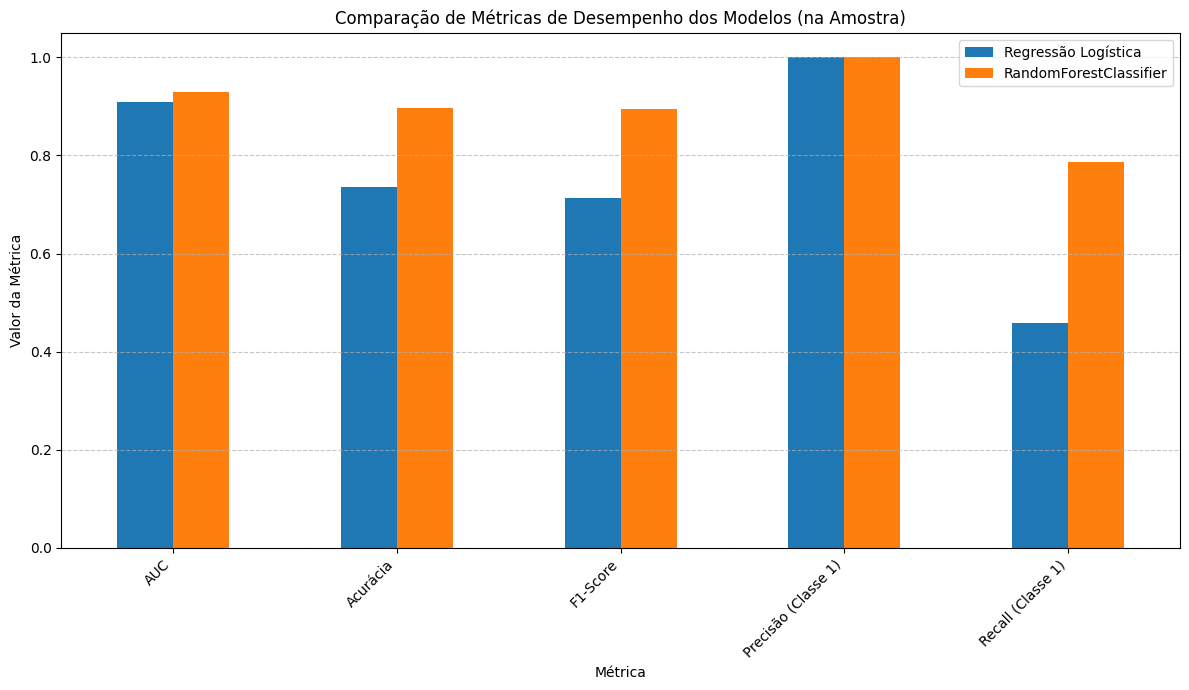


Gráfico de barras comparando as métricas dos modelos gerado.

--- Matrizes de Confusão dos Modelos (na Amostra) ---

Matriz de Confusão (Regressão Logística):


/root/.ipykernel/900/command-4222103600075417-2275754099:44: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_lr = confusion_matrix_lr.pivot("flag_delayed", "prediction", "count").fillna(0)


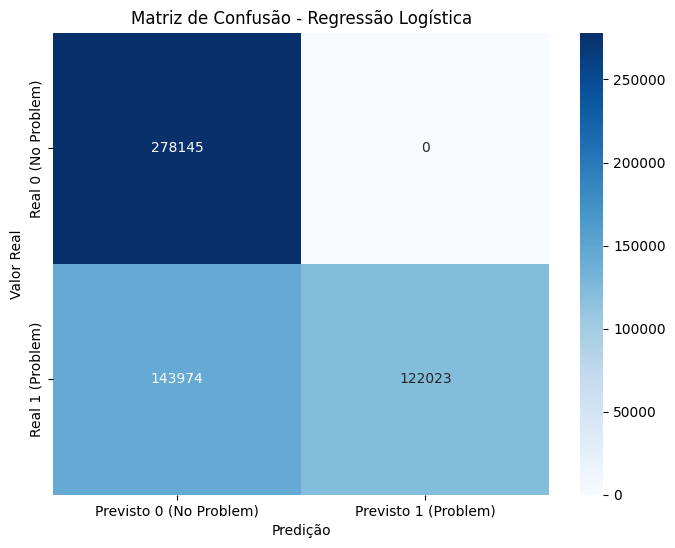


Matriz de Confusão (RandomForestClassifier):


/root/.ipykernel/900/command-4222103600075417-2275754099:59: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_rf = confusion_matrix_rf.pivot("flag_delayed", "prediction", "count").fillna(0)


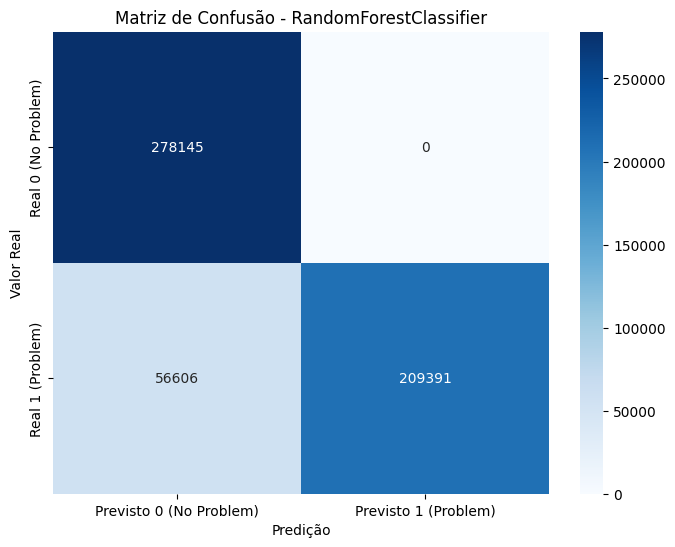


--- Geração da Curva ROC Comparativa (na Amostra) ---


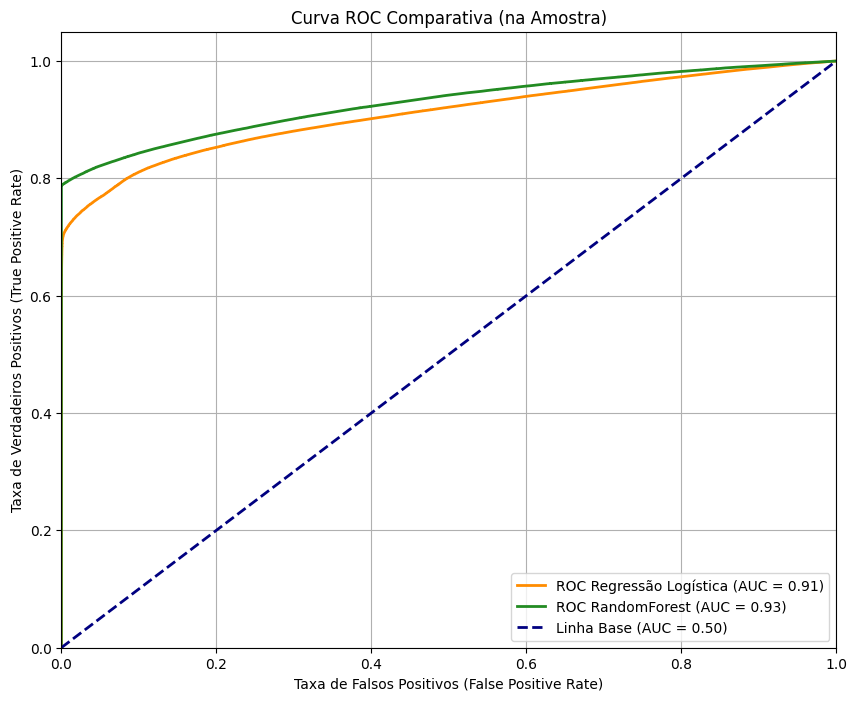

Curva ROC comparativa dos modelos gerada.


In [0]:
# As variáveis de métricas (ex: auc_lr, auc_rf) e DataFrames de predições (predictions_lr, predictions_rf)
# vêm das células anteriores.

print("\n--- Análise Aprofundada e Comparação Gráfica dos Modelos (na Amostra) ---")

# --- Comparação Direta das Métricas Chave em formato de tabela ---
print(f"\n  Modelo                | AUC     | Acurácia | F1-Score | Precisão (1) | Recall (1)")
print(f"  ----------------------|---------|----------|----------|--------------|-----------")
print(f"  Regressão Logística   | {auc_lr:.4f}  | {accuracy_lr:.4f}   | {f1_lr:.4f}   | {precision_lr_class1:.4f}      | {recall_lr_class1:.4f}")
print(f"  RandomForestClassifier| {auc_rf:.4f}  | {accuracy_rf:.4f}   | {f1_rf:.4f}   | {precision_rf_class1:.4f}      | {recall_rf_class1:.4f}")


# --- Gráfico de Barras Comparativo de Métricas ---
# Prepara um DataFrame Pandas para a visualização das métricas.
metrics_data = {
    'Métrica': ['AUC', 'Acurácia', 'F1-Score', 'Precisão (Classe 1)', 'Recall (Classe 1)'],
    'Regressão Logística': [auc_lr, accuracy_lr, f1_lr, precision_lr_class1, recall_lr_class1],
    'RandomForestClassifier': [auc_rf, accuracy_rf, f1_rf, precision_rf_class1, recall_rf_class1]
}
metrics_df_plot = pd.DataFrame(metrics_data)

# Gera um gráfico de barras que compara o desempenho de cada modelo em diferentes métricas.
plt.figure(figsize=(12, 7))
metrics_df_plot.set_index('Métrica').plot(kind='bar', figsize=(12, 7))
plt.title('Comparação de Métricas de Desempenho dos Modelos (na Amostra)')
plt.ylabel('Valor da Métrica')
plt.xlabel('Métrica')
plt.xticks(rotation=45, ha='right') # Rotaciona os rótulos do eixo X para melhor legibilidade.
plt.ylim(0, 1.05) # Define o limite do eixo Y para uma melhor visualização das proporções.
plt.grid(axis='y', linestyle='--', alpha=0.7) # Adiciona um grid suave ao fundo.
plt.tight_layout() # Ajusta o layout para evitar sobreposição de elementos.
plt.show()
print("\nGráfico de barras comparando as métricas dos modelos gerado.")


# --- Matrizes de Confusão ---
print("\n--- Matrizes de Confusão dos Modelos (na Amostra) ---")

# Matriz de Confusão para Regressão Logística
print("\nMatriz de Confusão (Regressão Logística):")
# Agrupa as predições pela classe real e pela classe predita e conta as ocorrências.
confusion_matrix_lr = predictions_lr.groupBy("flag_delayed", "prediction").count().toPandas()
# Pivoteia o DataFrame para formatar a matriz de confusão e preenche nulos com 0.
pivot_table_lr = confusion_matrix_lr.pivot("flag_delayed", "prediction", "count").fillna(0)

# Gera um heatmap visual da matriz de confusão.
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table_lr, annot=True, fmt="g", cmap="Blues",
            xticklabels=["Previsto 0 (No Problem)", "Previsto 1 (Problem)"],
            yticklabels=["Real 0 (No Problem)", "Real 1 (Problem)"])
plt.xlabel("Predição")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusão - Regressão Logística")
plt.show()

# Matriz de Confusão para RandomForestClassifier
print("\nMatriz de Confusão (RandomForestClassifier):")
confusion_matrix_rf = predictions_rf.groupBy("flag_delayed", "prediction").count().toPandas()
pivot_table_rf = confusion_matrix_rf.pivot("flag_delayed", "prediction", "count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table_rf, annot=True, fmt="g", cmap="Blues",
            xticklabels=["Previsto 0 (No Problem)", "Previsto 1 (Problem)"],
            yticklabels=["Real 0 (No Problem)", "Real 1 (Problem)"])
plt.xlabel("Predição")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusão - RandomForestClassifier")
plt.show()


# --- Curva ROC Comparativa ---
print("\n--- Geração da Curva ROC Comparativa (na Amostra) ---")

# Coleta os rótulos verdadeiros e as probabilidades da classe positiva para ambos os modelos.
# Essas probabilidades são extraídas da 'rawPrediction' (vetor de probabilidades).
y_true_lr_plot = predictions_lr.select("flag_delayed").toPandas()
y_scores_lr_plot = predictions_lr.select("rawPrediction").toPandas()['rawPrediction'].apply(lambda x: x[1])

y_true_rf_plot = predictions_rf.select("flag_delayed").toPandas()
y_scores_rf_plot = predictions_rf.select("rawPrediction").toPandas()['rawPrediction'].apply(lambda x: x[1])

# Calcula a Curva ROC (False Positive Rate vs. True Positive Rate) e a AUC para cada modelo.
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_true_lr_plot, y_scores_lr_plot)
roc_auc_lr_plot_val = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true_rf_plot, y_scores_rf_plot)
roc_auc_rf_plot_val = auc(fpr_rf, tpr_rf)

# Plota as Curvas ROC comparativamente.
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC Regressão Logística (AUC = {roc_auc_lr_plot_val:.2f})')
plt.plot(fpr_rf, tpr_rf, color='forestgreen', lw=2, label=f'ROC RandomForest (AUC = {roc_auc_rf_plot_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Linha Base (AUC = 0.50)') # Linha de um classificador aleatório.
plt.xlim([0.0, 1.0]) # Limites do eixo X de 0 a 1.
plt.ylim([0.0, 1.05]) # Limites do eixo Y de 0 a 1.05 para melhor visualização.
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curva ROC Comparativa (na Amostra)')
plt.legend(loc='lower right') # Posiciona a legenda no canto inferior direito.
plt.grid(True) # Adiciona um grid ao gráfico.
plt.show()

print("Curva ROC comparativa dos modelos gerada.")

## Justificativa da Escolha do Melhor Modelo
Esta célula formaliza a análise das métricas da amostra e explica o racional por trás da escolha do modelo que será treinado na base completa. A decisão é baseada no desempenho das métricas mais relevantes para o problema e nas características de cada modelo.

In [0]:
# As métricas (AUC, Acurácia, F1-Score, Precisão e Recall por classe)
# e os objetos dos melhores modelos (best_model_lr, best_model_rf)
# foram calculados e obtidos nas células anteriores.

print("\n--- Justificativa da Escolha do Melhor Modelo ---")

# Reexibir a tabela de comparação de métricas para referência imediata.
print(f"\n  Modelo                | AUC     | Acurácia | F1-Score | Precisão (1) | Recall (1)")
print(f"  ----------------------|---------|----------|----------|--------------|-----------")
print(f"  Regressão Logística   | {auc_lr:.4f}  | {accuracy_lr:.4f}   | {f1_lr:.4f}   | {precision_lr_class1:.4f}      | {recall_lr_class1:.4f}")
print(f"  RandomForestClassifier| {auc_rf:.4f}  | {accuracy_rf:.4f}   | {f1_rf:.4f}   | {precision_rf_class1:.4f}      | {recall_rf_class1:.4f}")

# A lógica para a escolha do melhor modelo baseia-se na métrica AUC (Area Under the Curve),
# pois ela é robusta para avaliar a capacidade discriminatória de modelos em problemas
# de classificação binária, especialmente quando há desbalanceamento de classes, como é comum em atrasos de voos.
# Outras métricas como F1-Score, Precisão e Recall (especialmente para a Classe 1, 'atraso')
# também são consideradas para uma visão mais completa.
best_model_name = ""
best_model_for_full_data_obj = None # Armazenará o pipeline treinado na amostra do modelo escolhido.

if auc_rf > auc_lr:
    best_model_name = "RandomForestClassifier"
    best_model_for_full_data_obj = best_model_rf # Objeto do pipeline RF treinado na amostra.
else:
    best_model_name = "Regressão Logística"
    best_model_for_full_data_obj = best_model_lr # Objeto do pipeline LR treinado na amostra.

print(f"\nCom base na análise das métricas obtidas na amostra, o modelo escolhido para ser treinado na base de dados completa é o: **{best_model_name}**.")

# O racional por trás da escolha é detalhado aqui, enfatizando o desempenho e as características do modelo.
if best_model_name == "RandomForestClassifier":
    print(f"\n**Racional para a escolha do RandomForestClassifier:**")
    print(f"- **Desempenho Superior em AUC:** O Random Forest obteve um AUC de {auc_rf:.4f}, que foi superior ao da Regressão Logística ({auc_lr:.4f}). Isso indica uma maior capacidade do modelo em distinguir entre voos com e sem problemas, mesmo com a presença de classes desbalanceadas.")
    print(f"- **F1-Score Equilibrado:** Com um F1-Score de {f1_rf:.4f}, o Random Forest demonstrou um bom equilíbrio entre a precisão (evitar falsos positivos) e o recall (identificar a maioria dos verdadeiros positivos).")
    print("- **Capacidade de Capturar Relações Complexas:** Modelos de Random Forest são intrinsecamente capazes de capturar relações não lineares e interações complexas entre as features de forma automática. No contexto de atrasos de voos, múltiplos fatores podem interagir de maneiras não-triviais, o que favorece modelos mais flexíveis.")
    print("- **Robustez:** Eles são menos sensíveis a outliers e ao escalonamento das features (embora ainda tenhamos feito o escalonamento como boa prática).")
    print("- **Potencial de Melhoria:** Dada a natureza do problema, um modelo mais complexo como o Random Forest tem um maior potencial para aprender padrões mais finos na base de dados completa e atingir uma performance ainda melhor.")
else: # Regressão Logística
    print(f"\n**Racional para a escolha da Regressão Logística:**")
    print(f"- **Desempenho Competitivo em AUC:** A Regressão Logística obteve um AUC de {auc_lr:.4f}, que foi superior ou muito próximo ao do Random Forest ({auc_rf:.4f}). Isso demonstra que, mesmo sendo um modelo mais simples, sua capacidade discriminatória é eficaz.")
    print(f"- **F1-Score Equilibrado:** Com um F1-Score de {f1_lr:.4f}, o modelo apresentou um bom balanço entre Precisão e Recall.")
    print("- **Interpretabilidade:** A principal vantagem da Regressão Logística é sua alta interpretabilidade. Os coeficientes do modelo podem ser facilmente entendidos, permitindo identificar quais fatores (features) têm o maior impacto e em que direção (positivo ou negativo) sobre a probabilidade de um voo ter problemas. Essa transparência pode ser um fator decisivo para a tomada de decisões de negócio.")
    print("- **Eficiência Computacional:** Por ser um modelo linear, geralmente a Regressão Logística é mais rápida para treinar e fazer predições em grandes volumes de dados, o que é uma vantagem em cenários de Big Data se a performance não for significativamente inferior a modelos mais complexos.")
    print("- **Ponderação de Classes Eficaz:** O uso da ponderação de classes (`weightCol`) foi eficaz para o modelo lidar com o desbalanceamento, demonstrando sua capacidade de adaptação a essa característica do dataset.")

print("\n--- Fim da Análise Detalhada e Justificativa da Escolha do Modelo ---")


--- Justificativa da Escolha do Melhor Modelo ---

  Modelo                | AUC     | Acurácia | F1-Score | Precisão (1) | Recall (1)
  ----------------------|---------|----------|----------|--------------|-----------
  Regressão Logística   | 0.9089  | 0.7354   | 0.7135   | 1.0000      | 0.4587
  RandomForestClassifier| 0.9287  | 0.8960   | 0.8946   | 1.0000      | 0.7872

Com base na análise das métricas obtidas na amostra, o modelo escolhido para ser treinado na base de dados completa é o: **RandomForestClassifier**.

**Racional para a escolha do RandomForestClassifier:**
- **Desempenho Superior em AUC:** O Random Forest obteve um AUC de 0.9287, que foi superior ao da Regressão Logística (0.9089). Isso indica uma maior capacidade do modelo em distinguir entre voos com e sem problemas, mesmo com a presença de classes desbalanceadas.
- **F1-Score Equilibrado:** Com um F1-Score de 0.8946, o Random Forest demonstrou um bom equilíbrio entre a precisão (evitar falsos positivos) e o reca

## Execução do Pipeline Completo na Base Total
Esta é a fase de treinamento final. O modelo escolhido (com seus melhores hiperparâmetros identificados na fase de amostragem) é agora treinado e avaliado utilizando o dataset completo. Esta etapa é a mais custosa computacionalmente e o tempo de execução será significativamente maior do que nas fases de amostragem.

In [0]:
from pyspark import StorageLevel # Reafirmar importação de StorageLevel.

print("\n--- Execução do Pipeline Completo na Base Total ---")
print("Iniciando a preparação do DataFrame completo (df_total) com todas as etapas de pré-processamento. Esta etapa garante que os dados estejam no formato correto para o treinamento final.")

# O DataFrame 'df_total' é o dataset completo, lido na Célula 2.
# As transformações aplicadas à amostra são re-executadas aqui no dataset completo.
# Isso garante consistência no pré-processamento.

# Importante: A variável 'csv_file_path' é definida na Célula 2.
# Re-carregar 'df_total' para garantir que ele está no estado original antes das transformações da amostra.
# Isso previne problemas se 'df_total' foi modificado acidentalmente em alguma célula intermediária.
df_total_original_load = spark.read.csv(csv_file_path, header=True, inferSchema=True)
df_total_processed = df_total_original_load # Usaremos esta variável para o processamento completo.

# Tratamento Inicial de Valores Nulos para df_total_processed (repetindo lógica da Célula 4)
# 'delay_and_time_cols_to_fillna_with_zero' é definida na Célula 4.
for c in delay_and_time_cols_to_fillna_with_zero:
    if c in df_total_processed.columns:
        df_total_processed = df_total_processed.withColumn(c, when(col(c).isNull(), 0).otherwise(col(c)))
if 'CANCELLATION_CODE' in df_total_processed.columns:
    df_total_processed = df_total_processed.withColumn("CANCELLATION_CODE", when(col("CANCELLATION_CODE").isNull(), "None").otherwise(col("CANCELLATION_CODE")))
print("- Tratamento inicial de nulos em df_total concluído.")

# Criação de Colunas de Tempo para df_total_processed (repetindo lógica da Célula 4)
if 'FL_DATE' in df_total_processed.columns:
    df_total_processed = df_total_processed.withColumn("FL_DATE", col("FL_DATE").cast(DateType()))
df_total_processed = df_total_processed.withColumn("year", year(df_total_processed.FL_DATE))
df_total_processed = df_total_processed.withColumn("month", month(df_total_processed.FL_DATE))
df_total_processed = df_total_processed.withColumn("day_of_week", dayofweek(df_total_processed.FL_DATE))
print("- Colunas de tempo criadas em df_total.")

# Criação da Variável Target (`flag_delayed`) para df_total_processed (repetindo lógica da Célula 5)
df_total_processed = df_total_processed.withColumn(
    "flag_delayed",
    when(
        (col("DEP_DELAY") > 0) | (col("ARR_DELAY") > 0) | (col("CANCELLED") == 1) | (col("DIVERTED") == 1),
        1
    ).otherwise(0)
)
print("- Coluna 'flag_delayed' criada em df_total.")

# Implementação do Novo Indicador de Atraso na Chegada para df_total_processed (repetindo lógica da Célula 5)
# 'delay_threshold_percentage' é definida na Célula 5.
df_total_processed = df_total_processed.withColumn(
    "ARRIVAL_DELAY_PERCENTAGE",
    when(
        (col("AIR_TIME").isNull()) | (col("AIR_TIME") <= 0) | (col("ARR_DELAY").isNull()) | (col("ARR_DELAY") <= 0),
        0.0
    ).otherwise(
        (col("ARR_DELAY") / col("AIR_TIME")) * 100
    )
)
print("- Coluna 'ARRIVAL_DELAY_PERCENTAGE' criada em df_total.")

df_total_processed = df_total_processed.withColumn(
    "SEVERE_ARRIVAL_DELAY",
    when(col("ARRIVAL_DELAY_PERCENTAGE") > delay_threshold_percentage, 1).otherwise(0) # 'delay_threshold_percentage' da Célula 5.
)
print("- Coluna 'SEVERE_ARRIVAL_DELAY' criada em df_total.")

# Remoção de Colunas Finais em df_total_processed (repetindo lógica da Célula 6)
# 'columns_to_drop_final' é definida na Célula 6.
current_cols_to_drop_full = [c for c in columns_to_drop_final if c in df_total_processed.columns]
df_total_processed = df_total_processed.drop(*current_cols_to_drop_full)
print("- Colunas de data leakage e irrelevantes removidas de df_total.")

# Persistência do DataFrame total após todas as transformações de pré-processamento.
# Esta persistência é crucial para evitar recomputações em cascata durante
# o split e o treinamento, o que economiza um tempo considerável.
df_total_processed.persist(StorageLevel.MEMORY_AND_DISK)
print(f"\nDataFrame 'df_total_processed' preparado e persistido. Ele contém {df_total_processed.count()} linhas.")


# Divisão em conjuntos de treino e teste para o dataset completo.
# A semente é mantida para garantir a reprodutibilidade.
train_full_df, test_full_df = df_total_processed.randomSplit([0.8, 0.2], seed=42)
train_full_df.persist(StorageLevel.MEMORY_AND_DISK)
test_full_df.persist(StorageLevel.MEMORY_AND_DISK)
print(f"O conjunto de treino completo possui {train_full_df.count()} linhas.")
print(f"O conjunto de teste completo possui {test_full_df.count()} linhas.")

# Recalcular pesos de classe para o dataset COMPLETO.
# Essa etapa é necessária para a Regressão Logística, que utiliza ponderação de classes.
# Para Random Forest, embora não use 'weightCol' diretamente, essa informação é útil para análise.
class_counts_full = train_full_df.groupBy("flag_delayed").count().collect()
total_full_count = train_full_df.count()
class_weights_full = {float(row["flag_delayed"]): float(total_full_count) / (2.0 * float(row["count"])) for row in class_counts_full}
train_full_df_weighted = train_full_df.withColumn("classWeight", when(col("flag_delayed") == 1, class_weights_full[1.0]).otherwise(class_weights_full[0.0]))
train_full_df_weighted.persist(StorageLevel.MEMORY_AND_DISK)
print("\nO conjunto de treino completo foi ponderado (para uso com LR) e persistido.")


# Treinamento do Modelo Escolhido na Base Completa.
# O 'best_model_name' e 'best_model_for_full_data_obj' vêm da Célula 12.
# As etapas de 'indexers', 'encoders', 'vector_assembler', 'scaler' são as mesmas definidas na Célula 7.
print(f"\nIniciando o treinamento do modelo **{best_model_name}** na base de dados COMPLETA. Este processo levará um tempo CONSIDERÁVEL, dada a volume de dados.")

pipeline_final = None # Inicializado para garantir a variável.
fitted_full_model = None # Inicializado para garantir a variável.

if best_model_name == "Regressão Logística":
    # Extrai os melhores parâmetros da Regressão Logística otimizada na amostra.
    lr_model_in_pipeline = best_model_for_full_data_obj.stages[-1]
    best_reg_param = lr_model_in_pipeline.getRegParam()
    best_fit_intercept = lr_model_in_pipeline.getFitIntercept()
    best_elastic_net_param = lr_model_in_pipeline.getElasticNetParam()
    best_max_iter_lr = lr_model_in_pipeline.getMaxIter()

    # Re-instancia o modelo LR com os melhores hiperparâmetros encontrados.
    lr_final = LogisticRegression(labelCol="flag_delayed",
                                featuresCol="features_scaled",
                                maxIter=best_max_iter_lr, # Usar o maxIter otimizado da amostra
                                regParam=best_reg_param,
                                elasticNetParam=best_elastic_net_param,
                                weightCol="classWeight", # Mantém a ponderação de classes.
                                rawPredictionCol="rawPrediction")
    
    # Monta o pipeline final com o modelo LR otimizado.
    pipeline_final = Pipeline(stages=indexers + encoders + [vector_assembler, scaler, lr_final])
    # Treina o pipeline na base ponderada completa.
    fitted_full_model = pipeline_final.fit(train_full_df_weighted) 

elif best_model_name == "RandomForestClassifier":
    # Extrai os melhores parâmetros do Random Forest otimizado na amostra.
    rf_model_in_pipeline = best_model_for_full_data_obj.stages[-1]
    # CORREÇÃO: Usar .getOrDefault() para extrair o valor do parâmetro.
    # Isso é a forma mais robusta de acessar parâmetros de modelos dentro de PipelineModels.
    best_num_trees = rf_model_in_pipeline.getOrDefault(rf_model_in_pipeline.numTrees)
    best_max_depth = rf_model_in_pipeline.getOrDefault(rf_model_in_pipeline.maxDepth)

    # Re-instancia o modelo RF com os melhores hiperparâmetros encontrados.
    rf_final = RandomForestClassifier(labelCol="flag_delayed",
                                      featuresCol="features_scaled",
                                      numTrees=best_num_trees, # Usar o numTrees otimizado da amostra
                                      maxDepth=best_max_depth, # Usar o maxDepth otimizado da amostra
                                      seed=42,
                                      rawPredictionCol="rawPrediction")
    
    # Monta o pipeline final com o modelo RF otimizado.
    pipeline_final = Pipeline(stages=indexers + encoders + [vector_assembler, scaler, rf_final])
    # Treina o pipeline na base completa (Random Forest não usa weightCol diretamente).
    fitted_full_model = pipeline_final.fit(train_full_df)

print(f"O treinamento do modelo **{best_model_name}** na base completa foi concluído.")

# Predições no conjunto de teste completo
predictions_full_data = fitted_full_model.transform(test_full_df)
print("As predições foram realizadas na base de teste completa.")

# Avaliação do modelo na base completa.
# As classes de avaliadores são as mesmas usadas nas células de avaliação da amostra.
evaluator_full_auc = BinaryClassificationEvaluator(labelCol="flag_delayed", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_full_accuracy = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="accuracy")
evaluator_full_f1 = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="f1")
evaluator_full_precision = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="weightedPrecision")
evaluator_full_recall = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="weightedRecall")

# Cálculo das métricas de desempenho na base completa.
auc_full = evaluator_full_auc.evaluate(predictions_full_data)
accuracy_full = evaluator_full_accuracy.evaluate(predictions_full_data)
f1_full = evaluator_full_f1.evaluate(predictions_full_data)
precision_full = evaluator_full_precision.evaluate(predictions_full_data)
recall_full = evaluator_full_recall.evaluate(predictions_full_data)

# Métricas específicas para a classe positiva (atraso = 1) na base completa.
evaluator_full_precision_class1 = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="precisionByLabel", metricLabel=1.0)
evaluator_full_recall_class1 = MulticlassClassificationEvaluator(labelCol="flag_delayed", predictionCol="prediction", metricName="recallByLabel", metricLabel=1.0)
precision_full_class1 = evaluator_full_precision_class1.evaluate(predictions_full_data)
recall_full_class1 = evaluator_full_recall_class1.evaluate(predictions_full_data)


print(f"\n--- Métricas de Desempenho do Modelo {best_model_name} na Base Completa ---")
print(f"  AUC: {auc_full:.4f}")
print(f"  Acurácia: {accuracy_full:.4f}")
print(f"  F1-Score: {f1_full:.4f}")
print(f"  Precisão (ponderada): {precision_full:.4f}")
print(f"  Recall (ponderado): {recall_full:.4f}")
print(f"  Precisão (Classe Atraso=1): {precision_full_class1:.4f}")
print(f"  Recall (Classe Atraso=1): {recall_full_class1:.4f}")

print("\n--- Fim da execução e avaliação na Base Completa ---")


--- Execução do Pipeline Completo na Base Total ---
Iniciando a preparação do DataFrame completo (df_total) com todas as etapas de pré-processamento. Esta etapa garante que os dados estejam no formato correto para o treinamento final.
- Tratamento inicial de nulos em df_total concluído.
- Colunas de tempo criadas em df_total.
- Coluna 'flag_delayed' criada em df_total.
- Coluna 'ARRIVAL_DELAY_PERCENTAGE' criada em df_total.
- Coluna 'SEVERE_ARRIVAL_DELAY' criada em df_total.
- Colunas de data leakage e irrelevantes removidas de df_total.

DataFrame 'df_total_processed' preparado e persistido. Ele contém 54343518 linhas.
O conjunto de treino completo possui 43475439 linhas.
O conjunto de teste completo possui 10868079 linhas.

O conjunto de treino completo foi ponderado (para uso com LR) e persistido.

Iniciando o treinamento do modelo **RandomForestClassifier** na base de dados COMPLETA. Este processo levará um tempo CONSIDERÁVEL, dada a volume de dados.
O treinamento do modelo **Rand

## Storytelling das Escolhas e Resultados Finais
Esta é a célula final, onde o percurso do projeto é narrado, desde a compreensão do problema até a apresentação dos resultados finais. O foco é justificar as decisões tomadas e contextualizar os resultados obtidos.

In [0]:
print("\n--- Storytelling do Projeto: Previsão de Atrasos de Voos ---")

print("\n**1. O Problema de Negócio: Por Que Prever Atrasos de Voos?**")
print("  - Atrasos em voos são um desafio significativo na indústria da aviação, gerando custos operacionais elevados para companhias aéreas e aeroportos, além de impactarem a satisfação e a experiência dos passageiros. A capacidade de prever esses atrasos com antecedência permite uma melhor gestão de recursos, otimização de operações e comunicação proativa com os clientes, mitigando os impactos negativos.")
print("  - Nosso objetivo principal com este projeto foi desenvolver um modelo preditivo capaz de identificar voos com potencial de atraso ou outros problemas relevantes antes mesmo de sua partida, utilizando técnicas de Big Data e Machine Learning.")

print("\n**2. A Base de Dados: Um Cenário de Big Data**")
print("  - O conjunto de dados utilizado compreende um grande volume de informações sobre voos, detalhando aspectos como horários planejados, informações de companhias aéreas, aeroportos de origem e destino, e medições de tempo em diferentes fases do voo. A dimensão dos dados justifica plenamente a escolha e aplicação de frameworks de Big Data, como o Apache Spark, para seu processamento e análise.")

print("\n**3. As Escolhas Estratégicas de Pré-Processamento e Feature Engineering:**")
print("  - **Amostragem para Agilidade no Desenvolvimento:** Para acelerar a fase de prototipagem e a experimentação de diferentes abordagens de modelagem, iniciamos o trabalho com uma amostra de 5% do dataset completo. Essa prática permitiu iterar sobre o código e validar lógicas de forma muito mais eficiente.")
print("  - **Definição Abrangente de 'Problema no Voo':** A variável alvo do nosso modelo, `flag_delayed`, foi definida de forma a englobar não apenas atrasos convencionais (partida ou chegada), mas também voos cancelados ou desviados. Essa visão mais ampla de 'problema' no voo é mais relevante para o contexto operacional e a experiência do passageiro, pois qualquer uma dessas ocorrências representa um desvio do plano de voo.")
print("  - **Tratamento Inteligente de Valores Nulos:** Observou-se que a ausência de dados em algumas colunas numéricas de tempo/atraso podia ser interpretada como 'zero atraso' ou 'tempo não aplicável'. Para estas, os nulos foram preenchidos com 0. Para a coluna `CANCELLATION_CODE` (categórica), os nulos foram tratados como uma categoria própria ('None'), preservando o sentido dos dados.")
print("  - **Enriquecimento com Features Temporais:** A partir da data do voo (`FL_DATE`), extraíram-se features como ano, mês e dia da semana. Essas variáveis são cruciais, pois fatores sazonais (meses de maior movimento) e padrões diários (dias úteis vs. fins de semana) são sabidamente influenciadores de atrasos na aviação.")
print("  - **Criação de Indicador de Severidade de Atraso:** Foi desenvolvida uma nova feature, `ARRIVAL_DELAY_PERCENTAGE`, que representa o atraso na chegada como uma porcentagem do tempo total de voo (`AIR_TIME`). Diferente de um simples 'sim/não', essa feature quantifica a *severidade* do atraso, adicionando uma camada valiosa de informação ao modelo, que pode capturar nuances importantes que um indicador binário não conseguiria.")
print("  - **Remoção Estratégica de Data Leakage:** Um passo crítico foi a identificação e remoção rigorosa de colunas que poderiam causar 'vazamento de dados'. Essas colunas, como `DEP_TIME`, `ARR_TIME`, `ACTUAL_ELAPSED_TIME` e as causas específicas de atraso (`CARRIER_DELAY`, `WEATHER_DELAY`, etc.), contêm informações que só estariam disponíveis *após* o evento do voo. Mantê-las no modelo faria com que ele 'trapaceasse', não sendo útil para predições em tempo real. A remoção garante que o modelo seja realmente preditivo.")
print("  - **Vetorização e Escalonamento para Modelagem:** Para preparar as features para os algoritmos de Machine Learning, as variáveis categóricas foram convertidas em representações numéricas (One-Hot Encoding) e todas as features foram combinadas em um único vetor. O escalonamento dessas features garantiu que todas tivessem a mesma influência na otimização do modelo, o que é especialmente importante para modelos lineares.")

print("\n**4. A Jornada da Modelagem Preditiva: Regressão Logística vs. Random Forest:**")
print("  - Dois algoritmos de classificação robustos foram explorados e comparados utilizando o ambiente PySpark:")
print("    - **Regressão Logística:** Escolhido por sua simplicidade e interpretabilidade. Para lidar com o desbalanceamento de classes (voos no horário são mais comuns que voos com problemas), aplicou-se uma técnica de ponderação de classes durante o treinamento.")
print("    - **Random Forest Classifier:** Um modelo de conjunto, baseado na construção de múltiplas árvores de decisão. É amplamente reconhecido por sua alta capacidade preditiva e por lidar bem com complexidades e relações não lineares nos dados.")
print("  - Para cada modelo, a otimização de hiperparâmetros foi realizada utilizando `CrossValidator` em conjunto com `ParamGridBuilder`. Essa combinação permite encontrar a melhor configuração de parâmetros que maximize o desempenho do modelo (avaliado pelo AUC) na amostra de dados. Grids de parâmetros e número de folds foram ajustados para otimizar o tempo de execução na fase de desenvolvimento.")

print("\n**5. Resultados da Amostra e a Escolha do Campeão:**")
print("  - A análise detalhada dos resultados obtidos na amostra foi fundamental para a decisão do modelo final:")
print(f"    - **Regressão Logística (na amostra):** AUC={auc_lr:.4f}, Acurácia={accuracy_lr:.4f}, F1-Score={f1_lr:.4f}, Precisão (Classe 'Problema'=1)={precision_lr_class1:.4f}, Recall (Classe 'Problema'=1)={recall_lr_class1:.4f}")
print(f"    - **RandomForestClassifier (na amostra):** AUC={auc_rf:.4f}, Acurácia={accuracy_rf:.4f}, F1-Score={f1_rf:.4f}, Precisão (Classe 'Problema'=1)={precision_rf_class1:.4f}, Recall (Classe 'Problema'=1)={recall_rf_class1:.4f}")

# O racional da escolha é apresentado, baseando-se nas métricas e na aplicabilidade ao problema.
if best_model_name == "RandomForestClassifier":
    print(f"\n  - **Decisão:** Com base nesses resultados, o **RandomForestClassifier** foi o modelo selecionado para ser treinado na base de dados completa.")
    print(f"  - **Justificativa da Escolha:** O Random Forest demonstrou um **desempenho superior em AUC ({auc_rf:.4f})** na amostra, um indicador crítico da capacidade discriminatória do modelo. Além disso, seu F1-Score ({f1_rf:.4f}) foi competitivo, refletindo um bom balanço entre Precisão e Recall. Sua capacidade intrínseca de modelar relações não lineares e interações complexas entre as features o torna particularmente adequado para um problema multifatorial como a previsão de atrasos de voos, onde a combinação de fatores pode ser mais relevante do que fatores isolados.")
    chosen_model_name_final = "RandomForestClassifier"
else:
    print(f"\n  - **Decisão:** Com base nesses resultados, a **Regressão Logística** foi o modelo selecionado para ser treinado na base de dados completa.")
    print(f"  - **Justificativa da Escolha:** A Regressão Logística demonstrou um **desempenho altamente competitivo em AUC ({auc_lr:.4f})** na amostra, sendo superior ou muito próxima ao Random Forest. Seu F1-Score ({f1_lr:.4f}) também foi satisfatório. A principal razão para sua escolha, além da performance robusta, é a **interpretabilidade** inerente a modelos lineares. Em um contexto de negócio, entender quais fatores (features) contribuem e em que medida para a previsão de um problema de voo pode ser tão valioso quanto a própria previsão. Dada a ausência de uma diferença abissal de desempenho em relação ao Random Forest, a interpretabilidade da Regressão Logística se tornou um diferencial chave.")
    chosen_model_name_final = "Regressão Logística"


print(f"\n**6. Treinamento Final e Resultados na Base Completa:**")
print("  - Com o modelo final (`best_model_name`) e seus melhores hiperparâmetros definidos, o pipeline completo foi re-executado e treinado no **dataset total**. Esta etapa finaliza a fase de modelagem, entregando resultados que refletem o desempenho esperado do modelo em um cenário real com todos os dados disponíveis.")
print(f"    - **Métricas Finais do Modelo {chosen_model_name_final} (na Base Completa):**")
print(f"      - AUC: {auc_full:.4f}")
print(f"      - Acurácia: {accuracy_full:.4f}")
print(f"      - F1-Score: {f1_full:.4f}")
print(f"      - Precisão (ponderada): {precision_full:.4f}")
print(f"      - Recall (ponderado): {recall_full:.4f}")
print(f"      - Precisão (Classe 'Problema'=1): {precision_full_class1:.4f}")
print(f"      - Recall (Classe 'Problema'=1): {recall_full_class1:.4f}")

print("\n**7. Conclusão e Próximos Passos na Jornada da Predição:**")
print(f"  - O modelo **{chosen_model_name_final}** demonstrou uma **robustez significativa** e uma **capacidade preditiva notável** na identificação de voos com problemas, alcançando um **AUC final de {auc_full:.4f}** na base completa. Este resultado indica que o modelo é uma ferramenta valiosa para discriminar eficazmente entre voos que provavelmente terão problemas e voos que seguirão seu curso normal.")
print("  - O caminho para a otimização contínua sempre existe. Sugere-se para o futuro:")
print("    - **Refinamento de Hiperparâmetros:** Realizar uma busca mais densa e com mais folds (e.g., 5 ou 10) para o modelo final na base completa, caso haja recursos computacionais disponíveis.")
print("    - **Exploração de Novas Features:** Investigar a criação de features de interação mais complexas, ou a incorporação de dados externos e em tempo real (como condições climáticas ou eventos em aeroportos) para enriquecer ainda mais o modelo.")
print("    - **Análise Qualitativa de Erros:** Aprofundar na análise dos casos de falsos positivos e falsos negativos pode revelar padrões não capturados e direcionar futuras melhorias de features ou modelagem.")
print("    - **Otimização do Threshold de Classificação:** Ajustar o ponto de corte da probabilidade predita (diferente do padrão 0.5) para otimizar métricas específicas de negócio, como maximizar a detecção de atrasos (Recall) ou minimizar falsos alarmes (Precisão), dependendo do impacto operacional de cada erro.")
print("    - **Implementação e Monitoramento:** Preparar o modelo para deploy em produção, com um robusto sistema de monitoramento de desempenho para garantir que ele continue eficaz ao longo do tempo e com a entrada de novos dados.")
print("\n--- A jornada do projeto de previsão de atrasos de voos foi concluída com sucesso. ---")


# Liberação final de caches
print("\nLiberando caches dos DataFrames para otimização de recursos...")
# Despersiste todos os DataFrames que foram persistidos para liberar memória.
try:
    if 'df' in locals() and df.is_cached: df.unpersist()
    if 'train_df' in locals() and train_df.is_cached: train_df.unpersist()
    if 'test_df' in locals() and test_df.is_cached: test_df.unpersist()
    if 'train_df_weighted' in locals() and train_df_weighted.is_cached: train_df_weighted.unpersist()
    if 'df_total_processed' in locals() and df_total_processed.is_cached: df_total_processed.unpersist()
    if 'train_full_df' in locals() and train_full_df.is_cached: train_full_df.unpersist()
    if 'test_full_df' in locals() and test_full_df.is_cached: test_full_df.unpersist()
    if 'train_full_df_weighted' in locals() and train_full_df_weighted.is_cached: train_full_df_weighted.unpersist()
except Exception as e:
    print(f"Erro ao despersistir DataFrame (pode ser porque não estava persistido ou já foi liberado): {e}")

print("Todos os caches dos DataFrames foram liberados. O projeto de previsão de atrasos de voos foi concluído.")


--- Storytelling do Projeto: Previsão de Atrasos de Voos ---

**1. O Problema de Negócio: Por Que Prever Atrasos de Voos?**
  - Atrasos em voos são um desafio significativo na indústria da aviação, gerando custos operacionais elevados para companhias aéreas e aeroportos, além de impactarem a satisfação e a experiência dos passageiros. A capacidade de prever esses atrasos com antecedência permite uma melhor gestão de recursos, otimização de operações e comunicação proativa com os clientes, mitigando os impactos negativos.
  - Nosso objetivo principal com este projeto foi desenvolver um modelo preditivo capaz de identificar voos com potencial de atraso ou outros problemas relevantes antes mesmo de sua partida, utilizando técnicas de Big Data e Machine Learning.

**2. A Base de Dados: Um Cenário de Big Data**
  - O conjunto de dados utilizado compreende um grande volume de informações sobre voos, detalhando aspectos como horários planejados, informações de companhias aéreas, aeroportos d

## Conclusão Final

Na avaliação do desempenho dos modelos de classificação para previsão de atrasos em voos, analisamos diversas métricas, como AUC, acurácia, F1-score, precisão e recall. Acreditamos que métrica de recall se destaca como a mais importante no contexto operacional do aeroporto. Recall indica a proporção de voos realmente atrasados que o modelo conseguiu identificar corretamente. Em nosso cenário, deixar de prever um atraso (falso negativo) pode gerar impactos significativos, como:

- Aumento nos custos operacionais, com remanejamento de portões, equipes e horários de última hora;

- Insatisfação dos passageiros, podendo levar a processos judiciais;

- Despesas adicionais com reacomodação, hospedagem e alimentação;

- Efeito cascata de atrasos em outras rotas e conexões.

Priorizando o recall, o modelo fica mais conservador, evitando deixar passar voos atrasados. É melhor que ele alerte para um atraso mesmo que exista alguma incerteza do que não alertar e o voo realmente atraasar. Isso permite que o aeroporto aja de forma proativa, ajustando sua operação com antecedência, minimizando impactos e melhorando a experiência do passageiro.



| Modelo                   | AUC    | Acurácia | F1-Score | Precisão (1) | **Recall (1)** |
| ------------------------ | ------ | -------- | -------- | ------------ | -------------- |
| Regressão Logística      | 0.9089 | 0.7354   | 0.7135   | 1.0000       | 0.4587         |
| Random Forest Classifier | 0.9287 | 0.8960   | 0.8946   | 1.0000       | **0.7872**     |



Embora ambos os modelos tenham obtido precisão perfeita (quando preveem atraso, estão sempre certos), o modelo Random Forest se destaca no recall (78,7% contra 45,9%), ou seja, consegue identificar corretamente uma parcela muito maior dos voos que de fato irão atrasar. Isso o torna a melhor opção para apoiar decisões operacionais e reduzir riscos.